# Rossmann Stores Sales Analysis

## Problem Statement

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In this exercise, we are going to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, we will help store managers stay focused on what’s most important to them: their customers and their teams! 


## Hypothesis Statement

H0: There is no direct correlation between numbers of Rossmann customers and volumes of sales at the stores.

H1: The number of customers influence the volumes of sales at Rossmann stores. The greater the number of customers, the higher the volume of sales. The less the number of customers, the lower the volume of sales.


## Data Understanding

We have historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.


### Files
- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- sample_submission.csv - a sample submission file in the correct format
- store.csv - supplemental information about the stores


## Business Problem

Predict the sales figures of the Roseman stores for the next n weeks

## Data Analysis

In [1]:
# Module Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import missingno as msno
import sklearn as sk
from matplotlib import pyplot as plt
from scipy import stats
import warnings
import plotly.express as px
import plotly.offline as pyo

import plotly.io as pio
pio.renderers.default = 'notebook'


# suppress scientific notation in Pandas
pd.options.display.float_format = "{:,.2f}".format
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", None)

plt.rcParams["figure.figsize"] = [12, 10]
plt.rcParams["figure.dpi"] = 150

sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
sns.set_theme(style="darkgrid")

pyo.init_notebook_mode()

warnings.filterwarnings("ignore")

RANDOM_STATE = 1


### Loading Training and Test Data

In [2]:
train_df = pd.read_csv('./sales_data/train.csv')

test_df = pd.read_csv('./sales_data/test.csv')

frames = [train_df, test_df]
 
df = pd.concat(frames)

df.to_csv('./sales_data/combined.csv', index=False)


### Inspect Training Data

In [3]:
df.info(verbose=True, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 1058297 entries, 0 to 41087
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Store          1058297 non-null  int64  
 1   DayOfWeek      1058297 non-null  int64  
 2   Date           1058297 non-null  object 
 3   Sales          1017209 non-null  float64
 4   Customers      1017209 non-null  float64
 5   Open           1058286 non-null  float64
 6   Promo          1058297 non-null  int64  
 7   StateHoliday   1058297 non-null  object 
 8   SchoolHoliday  1058297 non-null  int64  
 9   Id             41088 non-null    float64
dtypes: float64(4), int64(4), object(2)
memory usage: 196.1 MB


In [4]:
df.shape

# Training Set => 1,017,209 rows

(1058297, 10)

In [5]:
df.head()

Store  DayOfWeek        Date     Sales  Customers  Open  Promo  \
0      1          5  2015-07-31  5,263.00     555.00  1.00      1   
1      2          5  2015-07-31  6,064.00     625.00  1.00      1   
2      3          5  2015-07-31  8,314.00     821.00  1.00      1   
3      4          5  2015-07-31 13,995.00   1,498.00  1.00      1   
4      5          5  2015-07-31  4,822.00     559.00  1.00      1   

  StateHoliday  SchoolHoliday  Id  
0            0              1 NaN  
1            0              1 NaN  
2            0              1 NaN  
3            0              1 NaN  
4            0              1 NaN

In [6]:
df.tail()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
41083   1111          6  2015-08-01    NaN        NaN  1.00      0   
41084   1112          6  2015-08-01    NaN        NaN  1.00      0   
41085   1113          6  2015-08-01    NaN        NaN  1.00      0   
41086   1114          6  2015-08-01    NaN        NaN  1.00      0   
41087   1115          6  2015-08-01    NaN        NaN  1.00      0   

      StateHoliday  SchoolHoliday        Id  
41083            0              0 41,084.00  
41084            0              0 41,085.00  
41085            0              0 41,086.00  
41086            0              0 41,087.00  
41087            0              1 41,088.00

In [7]:
df.describe()

Store    DayOfWeek        Sales    Customers         Open  \
count 1,058,297.00 1,058,297.00 1,017,209.00 1,017,209.00 1,058,286.00   
mean        558.33         4.00     5,773.82       633.15         0.83   
std         321.85         2.00     3,849.93       464.41         0.37   
min           1.00         1.00         0.00         0.00         0.00   
25%         280.00         2.00     3,727.00       405.00         1.00   
50%         558.00         4.00     5,744.00       609.00         1.00   
75%         837.00         6.00     7,856.00       837.00         1.00   
max       1,115.00         7.00    41,551.00     7,388.00         1.00   

             Promo  SchoolHoliday        Id  
count 1,058,297.00   1,058,297.00 41,088.00  
mean          0.38           0.19 20,544.50  
std           0.49           0.39 11,861.23  
min           0.00           0.00      1.00  
25%           0.00           0.00 10,272.75  
50%           0.00           0.00 20,544.50  
75%           1.00           0.00 30,816.25  
max           1.00           1.00 41,088.00

### Data Analysis

#### Check for Null Values

In [8]:
# df.dropna(inplace=True)

In [9]:
df.isnull().sum()

Store                  0
DayOfWeek              0
Date                   0
Sales              41088
Customers          41088
Open                  11
Promo                  0
StateHoliday           0
SchoolHoliday          0
Id               1017209
dtype: int64

In [10]:
(df.isnull().sum()/(len(df))) * 100

Store            0.00
DayOfWeek        0.00
Date             0.00
Sales            3.88
Customers        3.88
Open             0.00
Promo            0.00
StateHoliday     0.00
SchoolHoliday    0.00
Id              96.12
dtype: float64

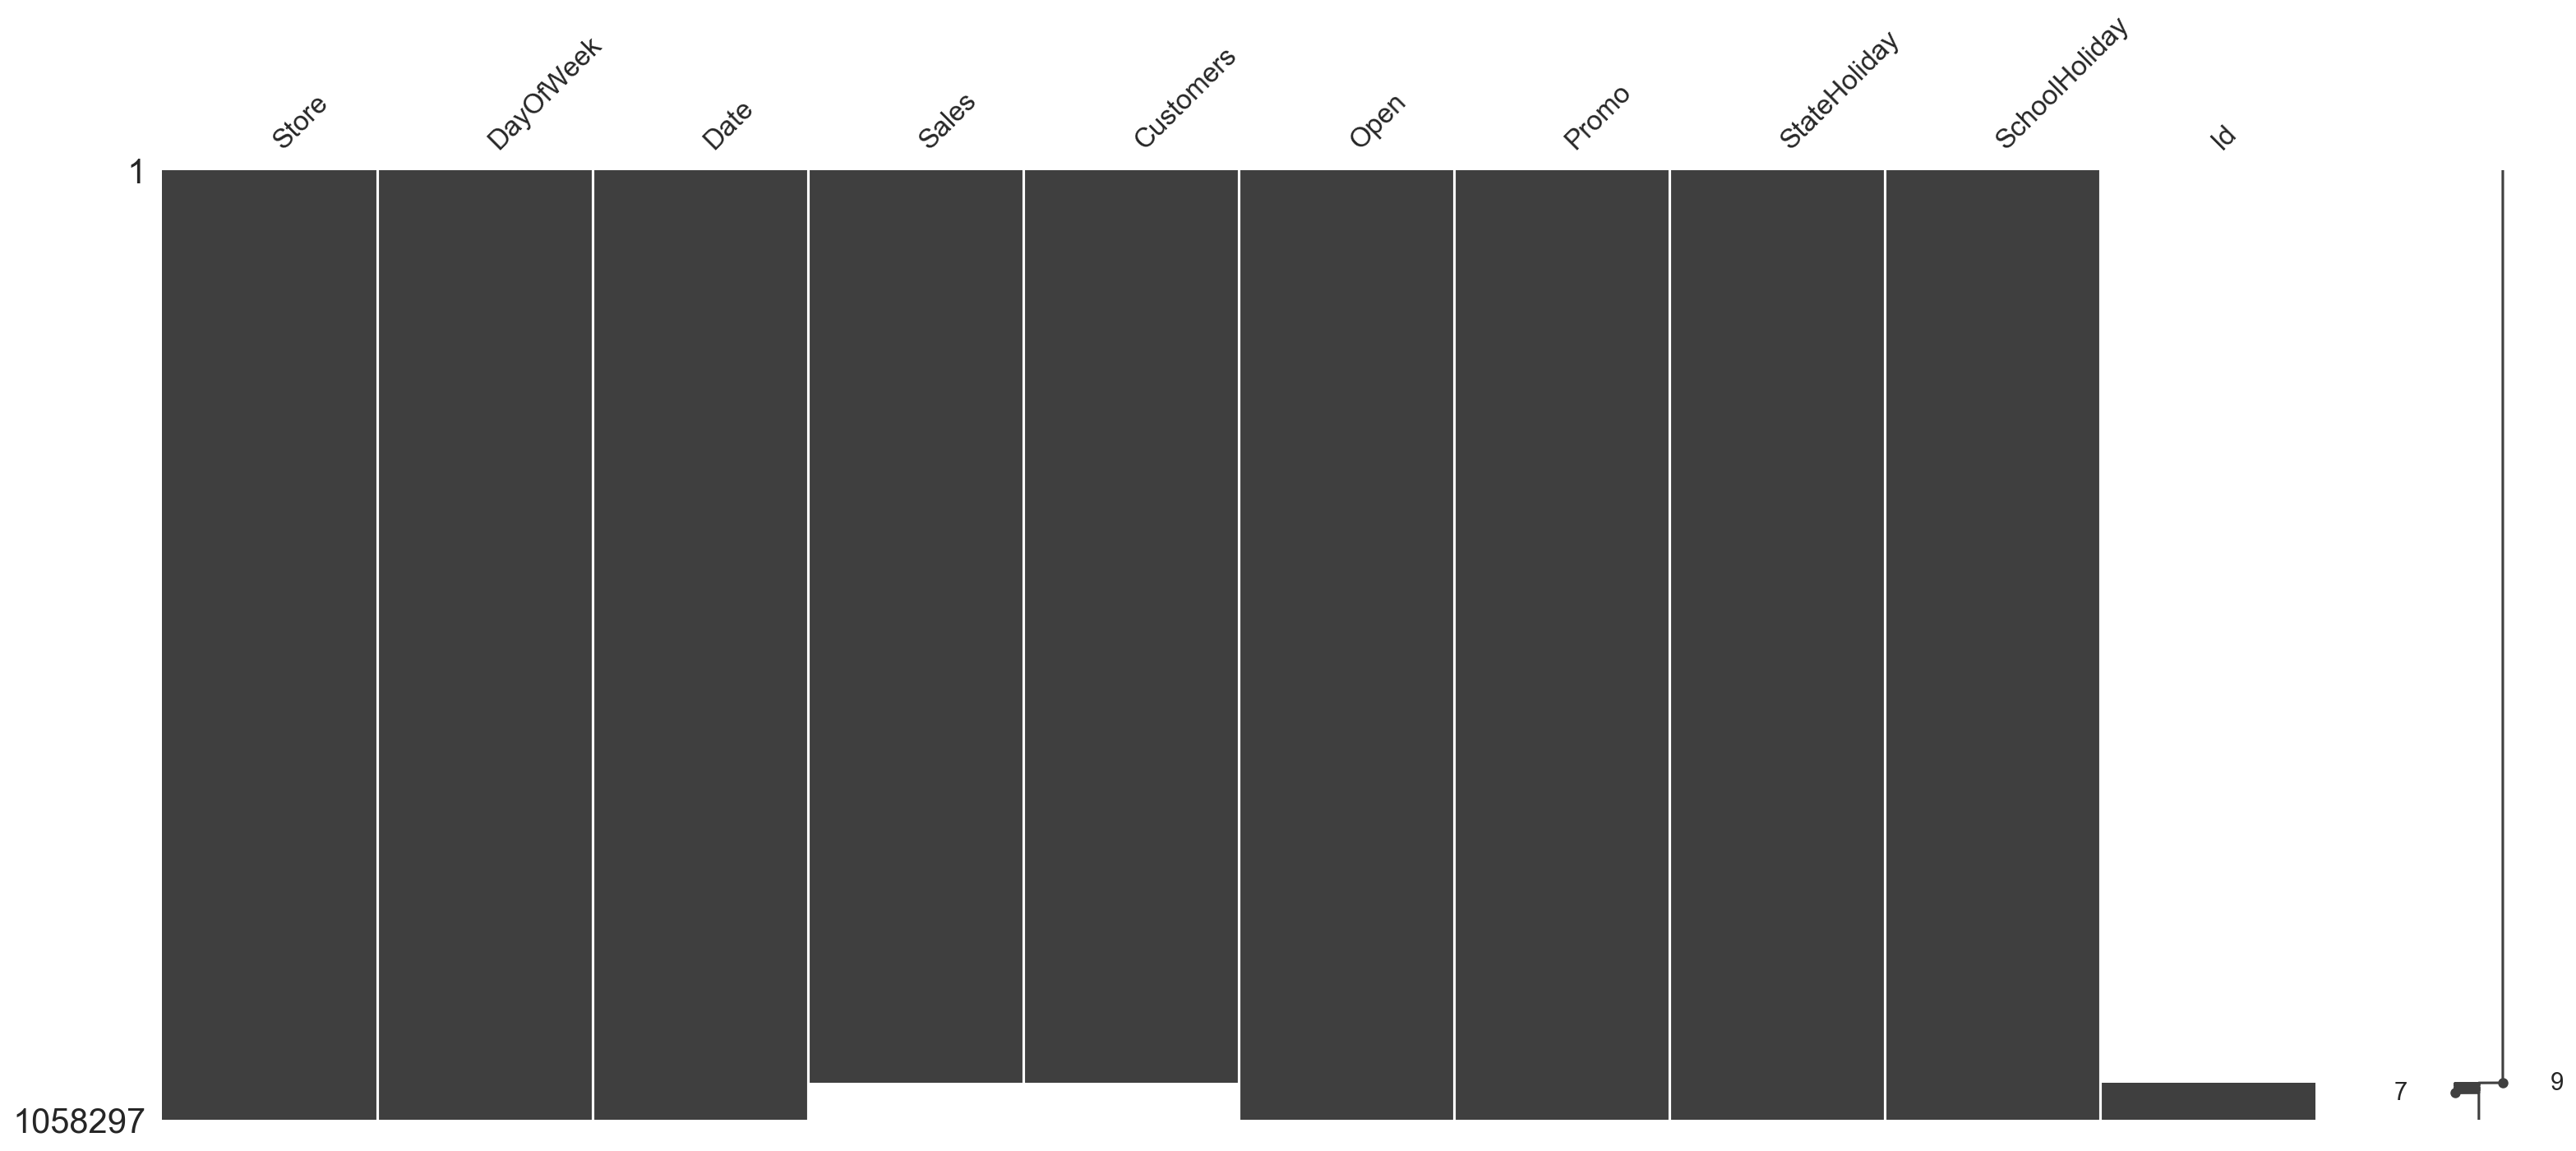

In [11]:
_ = msno.matrix(df)

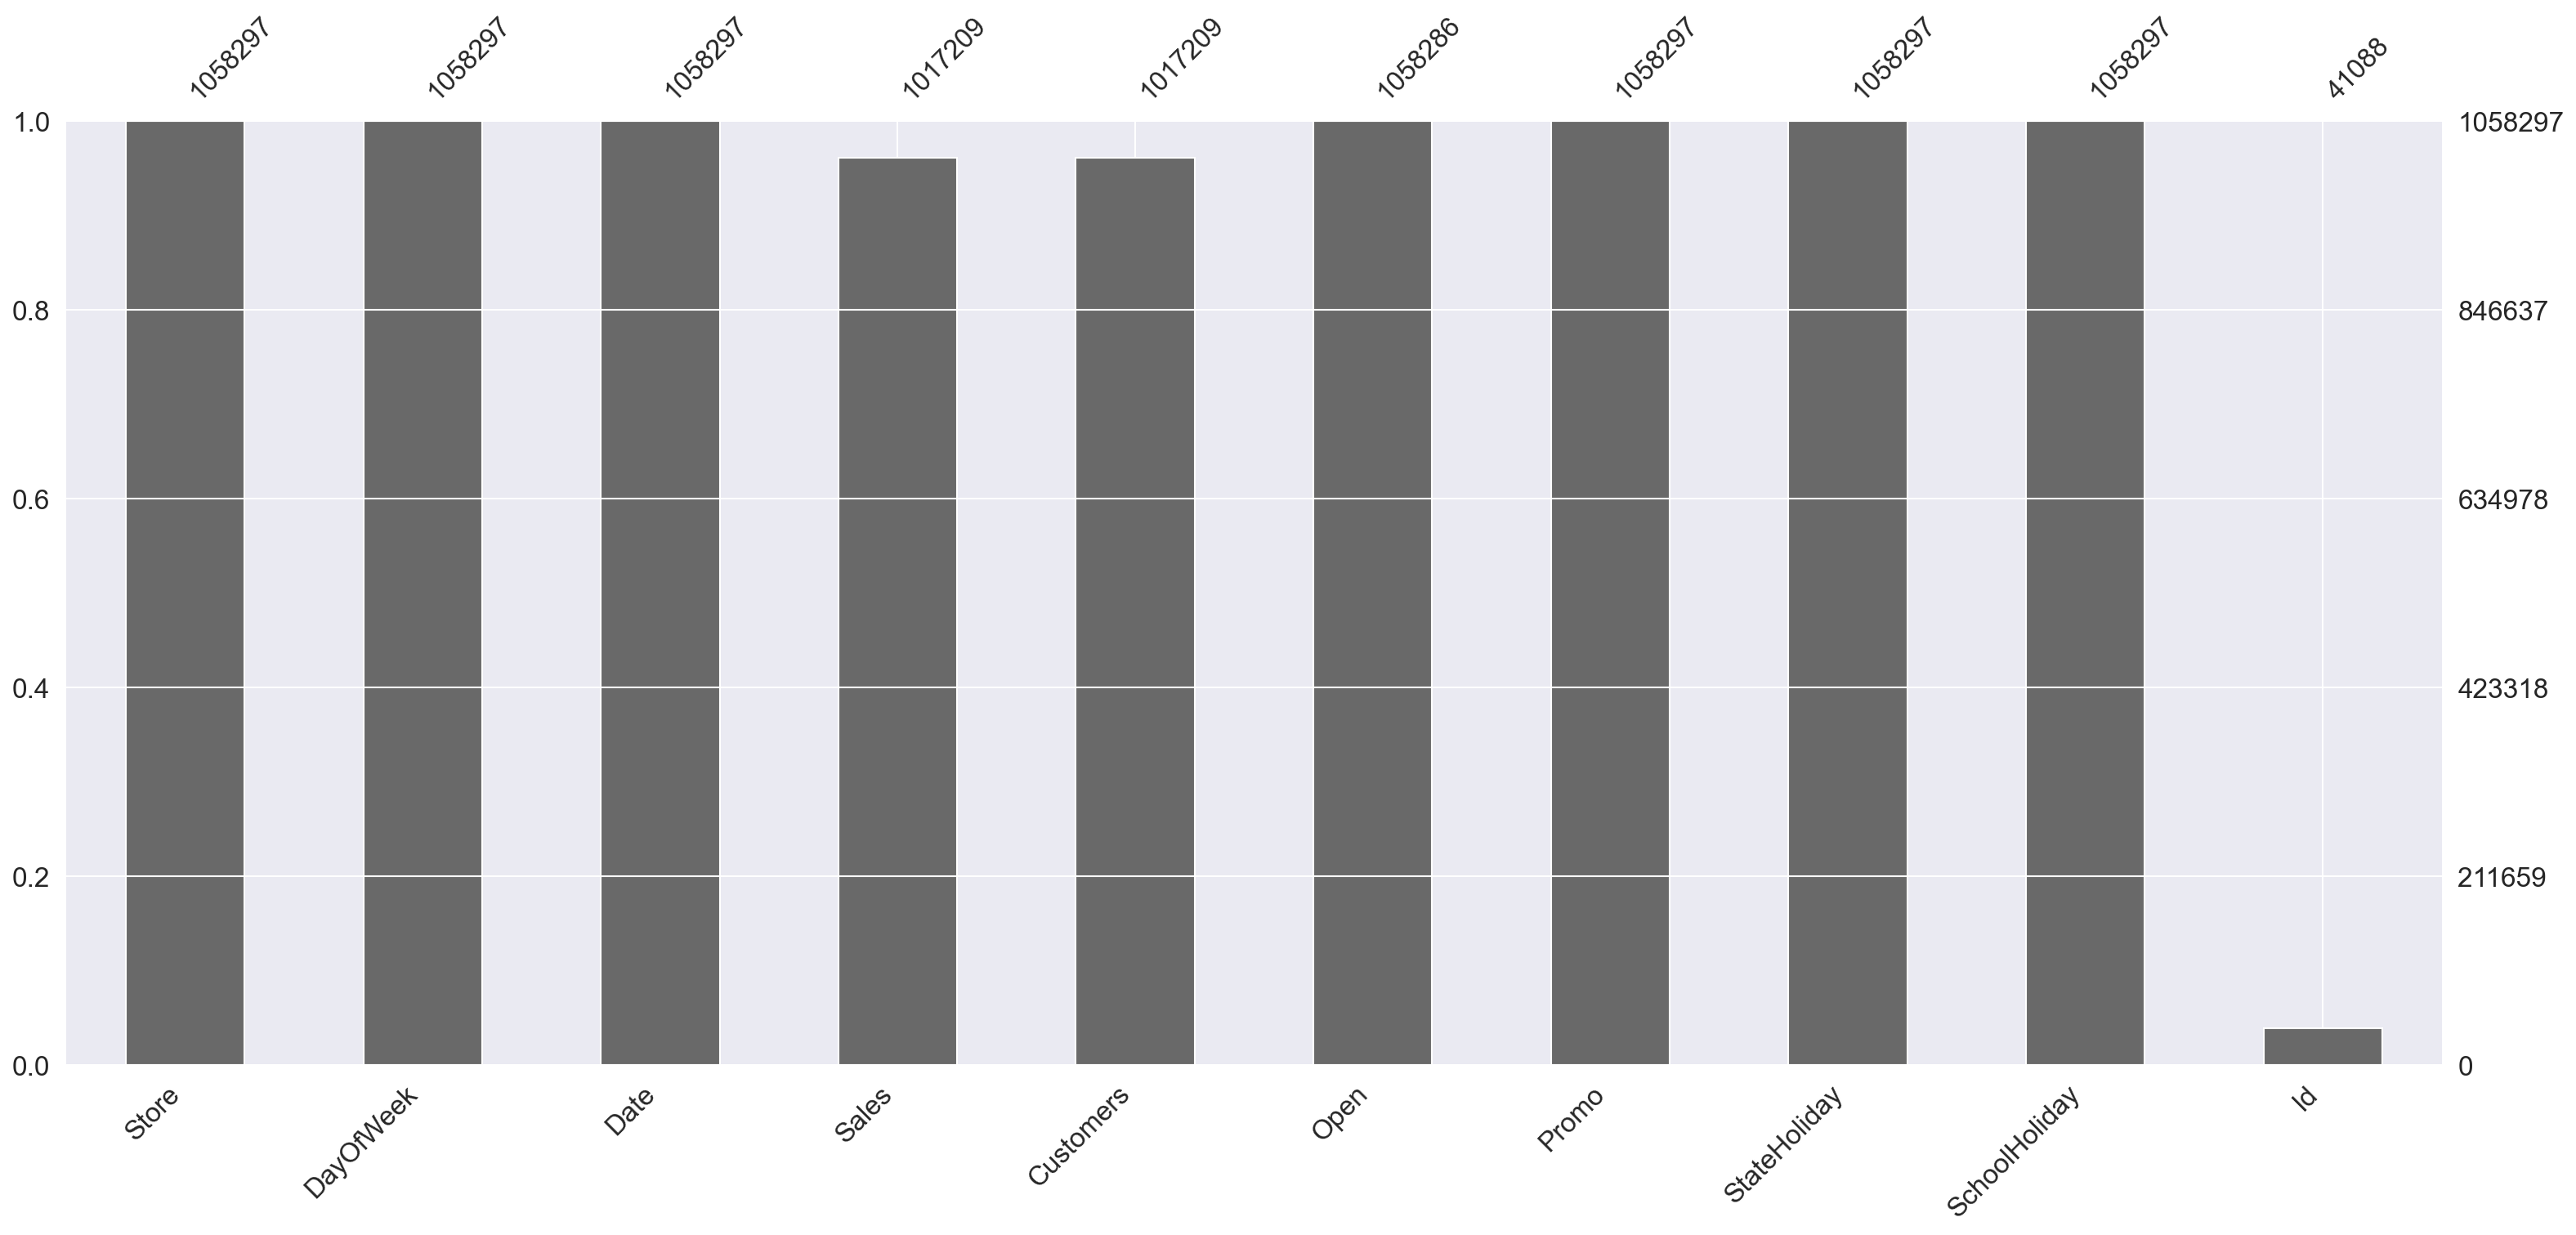

In [12]:
_ = msno.bar(df)

#### Check for Dupes

In [13]:
df[df.duplicated()]

Empty DataFrame
Columns: [Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday, Id]
Index: []

#### Correlation Mapping

##### Heatmap

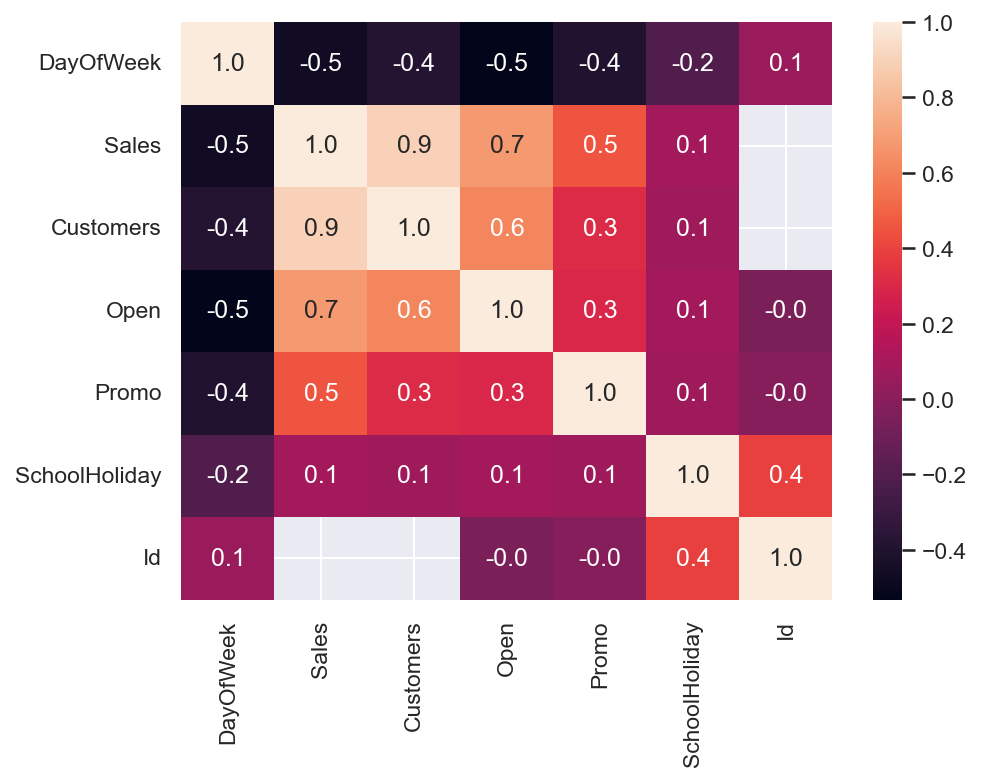

In [14]:
# <class 'pandas.core.frame.DataFrame'>
# Index: 1058297 entries, 0 to 41087
# Data columns (total 10 columns):
#  #   Column         Non-Null Count    Dtype  
# ---  ------         --------------    -----  
#  0   Store          1058297 non-null  int64  
#  1   DayOfWeek      1058297 non-null  int64  
#  2   Date           1058297 non-null  object 
#  3   Sales          1017209 non-null  float64
#  4   Customers      1017209 non-null  float64
#  5   Open           1058286 non-null  float64
#  6   Promo          1058297 non-null  int64  
#  7   StateHoliday   1058297 non-null  object 
#  8   SchoolHoliday  1058297 non-null  int64  
#  9   Id             41088 non-null    float64
# dtypes: float64(4), int64(4), object(2)
# memory usage: 196.1 MB

numeric_df = df[['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'Id']]

plt.figure(figsize=(7, 5))

_ = sns.heatmap(numeric_df.corr(), annot=True, fmt=".1f")

##### Pairplot

<Figure size 1050x600 with 0 Axes>

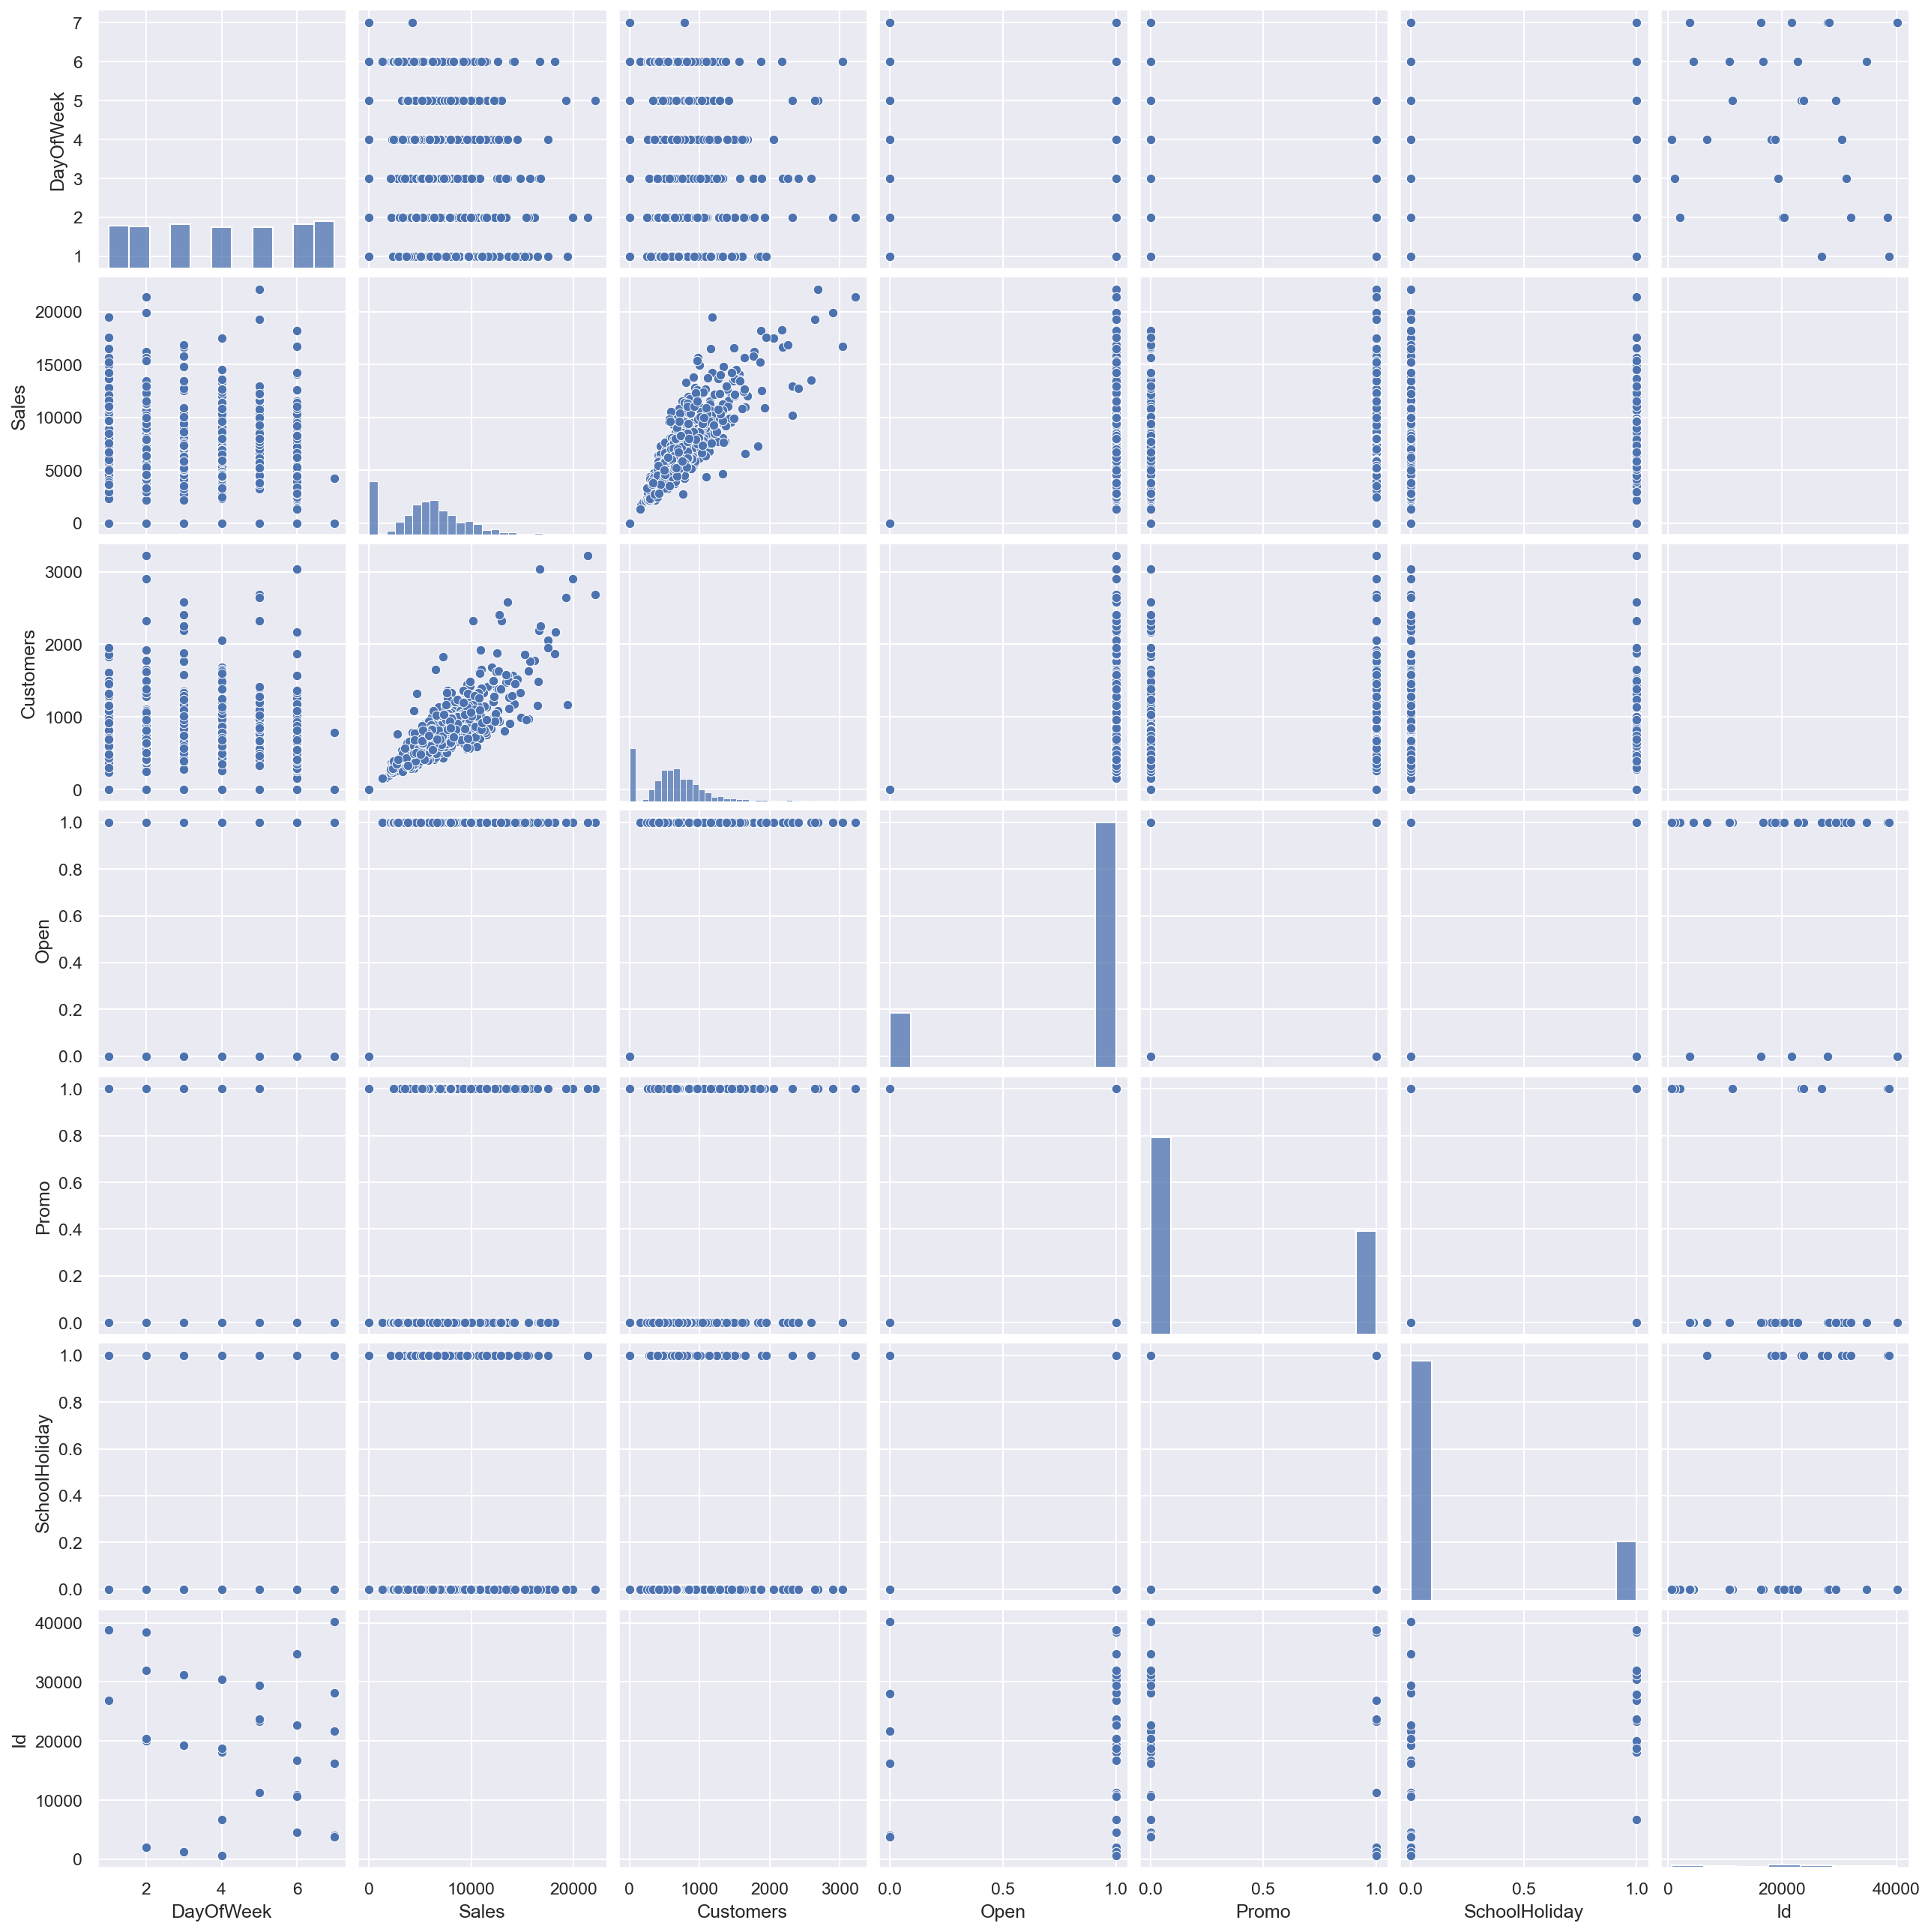

In [15]:
_ = plt.figure(figsize=(7, 4))

_ = sns.pairplot(numeric_df.sample(1000))

#### Visualization

##### Box Plots

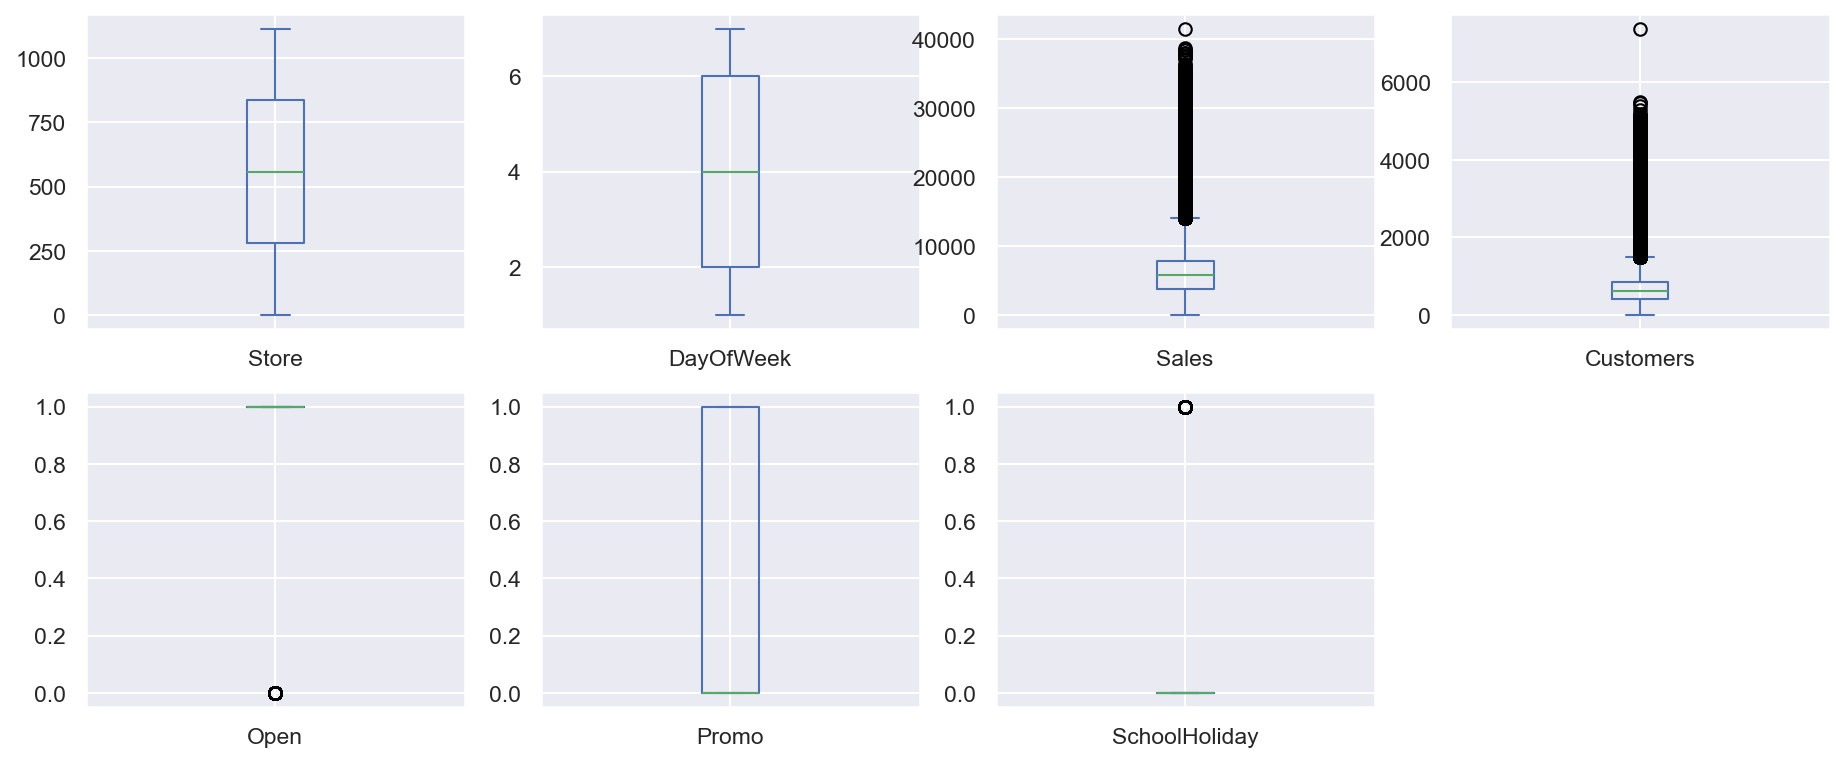

In [16]:
boxplot_cols = ['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday']

_ = df[boxplot_cols].plot(kind='box', subplots=True, layout=(2,4), figsize=(15, 6))

##### Sales Across Stores

In [17]:
numeric_df = df[['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday']]

numeric_df

Store  DayOfWeek     Sales  Customers  Open  Promo  SchoolHoliday
0          1          5  5,263.00     555.00  1.00      1              1
1          2          5  6,064.00     625.00  1.00      1              1
2          3          5  8,314.00     821.00  1.00      1              1
3          4          5 13,995.00   1,498.00  1.00      1              1
4          5          5  4,822.00     559.00  1.00      1              1
...      ...        ...       ...        ...   ...    ...            ...
41083   1111          6       NaN        NaN  1.00      0              0
41084   1112          6       NaN        NaN  1.00      0              0
41085   1113          6       NaN        NaN  1.00      0              0
41086   1114          6       NaN        NaN  1.00      0              0
41087   1115          6       NaN        NaN  1.00      0              1

[1058297 rows x 7 columns]

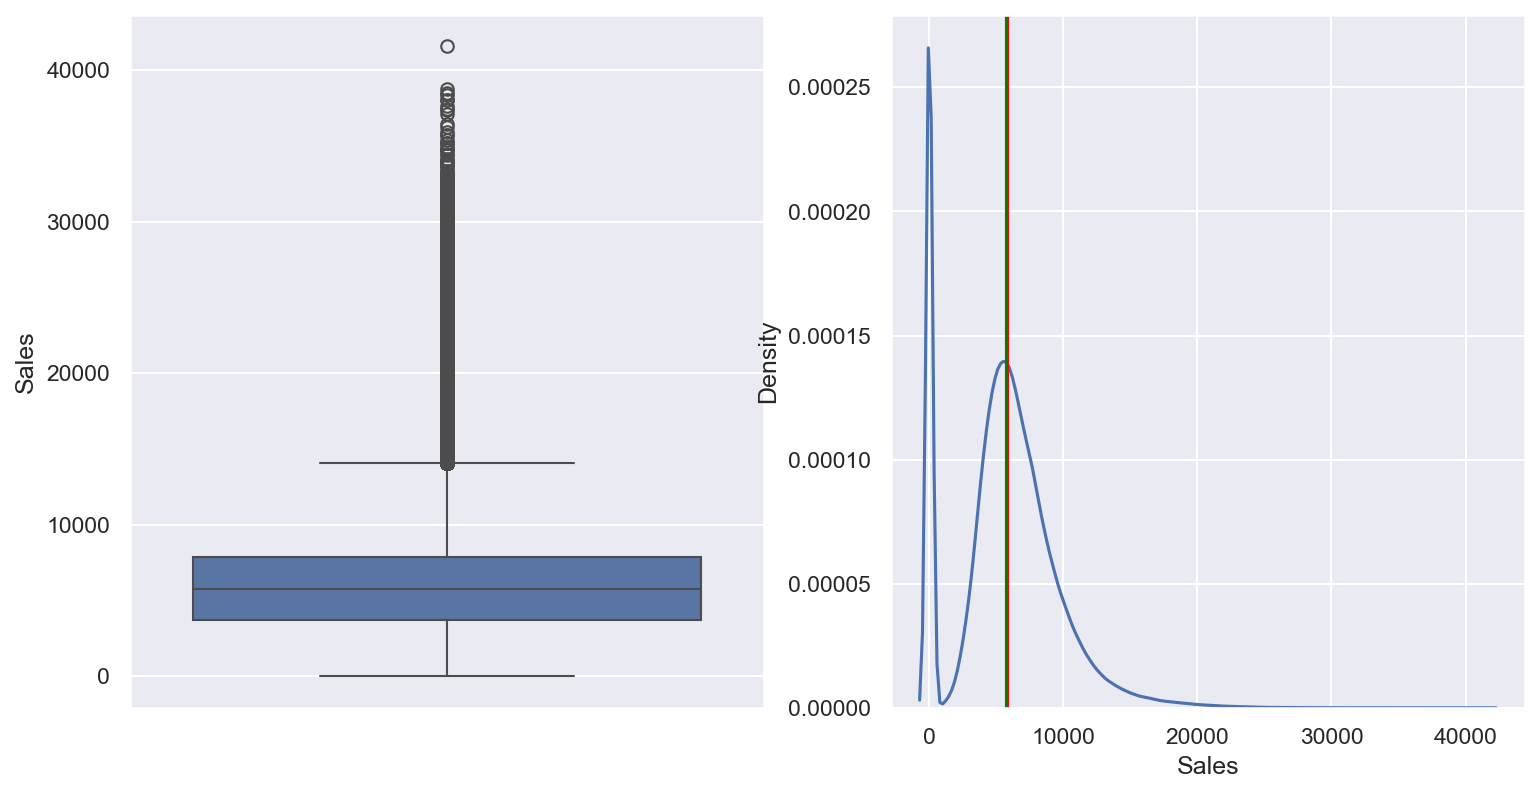

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6)) 

sns.boxplot(numeric_df['Sales'], ax=ax1)
sns.kdeplot(numeric_df['Sales'], ax=ax2)

ax2.axvline(numeric_df['Sales'].mean(), color='red')
ax2.axvline(numeric_df['Sales'].median(), color='green')

plt.show()

##### Customers Across Stores

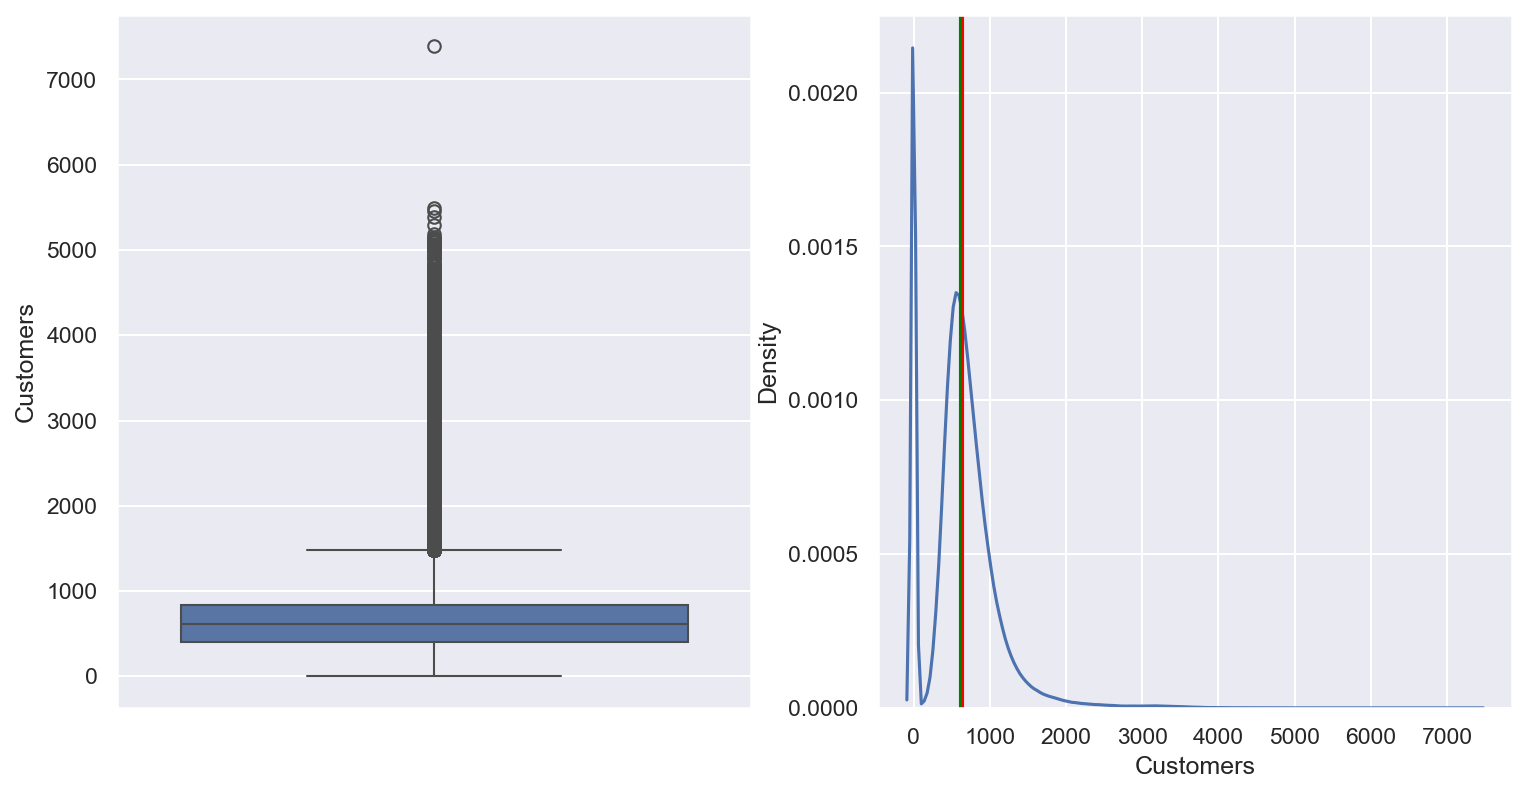

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6)) 

sns.boxplot(numeric_df['Customers'], ax=ax1)
sns.kdeplot(numeric_df['Customers'], ax=ax2)

ax2.axvline(numeric_df['Customers'].mean(), color='red')
ax2.axvline(numeric_df['Customers'].median(), color='green')

plt.show()

#### Seasonality

##### Customers and Sales by DayOfWeek

In [20]:
dayofweek_sales_df = df.groupby(['DayOfWeek'])[['Sales', 'Customers']].agg(['sum', 'mean', 'max', 'std', 'median'])

dayofweek_sales_df

Sales                                       \
                       sum     mean       max      std   median   
DayOfWeek                                                         
1         1,130,203,012.00 7,809.04 41,551.00 4,016.53 7,310.00   
2         1,020,411,930.00 7,005.24 34,692.00 3,142.04 6,463.00   
3           954,962,863.00 6,555.88 33,151.00 2,944.38 6,133.00   
4           911,177,709.00 6,247.58 38,367.00 3,209.81 6,020.00   
5           980,555,941.00 6,723.27 38,722.00 3,101.01 6,434.00   
6           846,317,735.00 5,847.56 31,683.00 2,873.99 5,410.00   
7            29,551,433.00   204.18 37,376.00 1,613.24     0.00   

               Customers                                
                     sum   mean      max    std median  
DayOfWeek                                               
1         117,675,012.00 813.07 5,387.00 449.62 748.00  
2         110,848,063.00 760.98 7,388.00 396.28 680.00  
3         105,117,642.00 721.64 5,106.00 385.88 651.00  
4         101,732,938.00 697.54 5,297.00 416.07 646.00  
5         108,384,820.00 743.15 5,494.00 410.06 682.00  
6          95,103,854.00 657.11 4,762.00 387.83 571.00  
7           5,179,426.00  35.79 5,145.00 284.61   0.00

In [21]:
seasonality_df = df[['Store', 'Sales', 'Customers', 'DayOfWeek', 'Date']]

seasonality_df.Date = pd.to_datetime(seasonality_df.Date)
seasonality_df['Day'] = seasonality_df.Date.dt.day
seasonality_df['Month'] = seasonality_df.Date.dt.month
seasonality_df['Year'] = seasonality_df.Date.dt.year

seasonality_df.sort_values(by=['Date'])

seasonality_df.drop(columns=['Date'])

Store     Sales  Customers  DayOfWeek  Day  Month  Year
0          1  5,263.00     555.00          5   31      7  2015
1          2  6,064.00     625.00          5   31      7  2015
2          3  8,314.00     821.00          5   31      7  2015
3          4 13,995.00   1,498.00          5   31      7  2015
4          5  4,822.00     559.00          5   31      7  2015
...      ...       ...        ...        ...  ...    ...   ...
41083   1111       NaN        NaN          6    1      8  2015
41084   1112       NaN        NaN          6    1      8  2015
41085   1113       NaN        NaN          6    1      8  2015
41086   1114       NaN        NaN          6    1      8  2015
41087   1115       NaN        NaN          6    1      8  2015

[1058297 rows x 7 columns]

##### Sales x Day

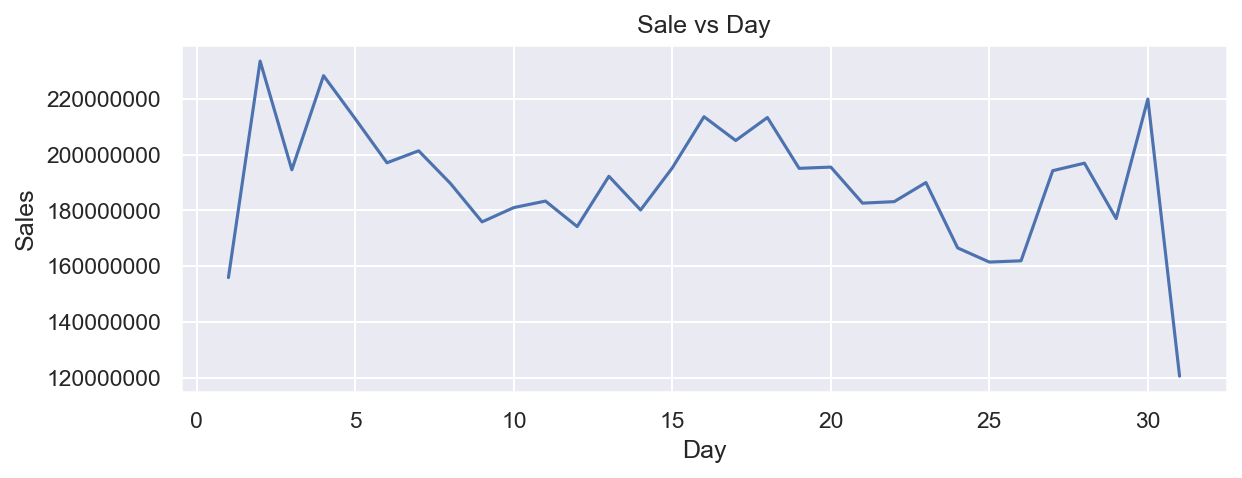

In [22]:
plt.figure(figsize=(9,3))
plt.ticklabel_format(style='plain', axis='y')
plt.plot(seasonality_df.groupby('Day')['Sales'].sum().round())
plt.title("Sale vs Day")
plt.xlabel('Day')
plt.ylabel('Sales')
plt.show()

##### Sales x Day of Week

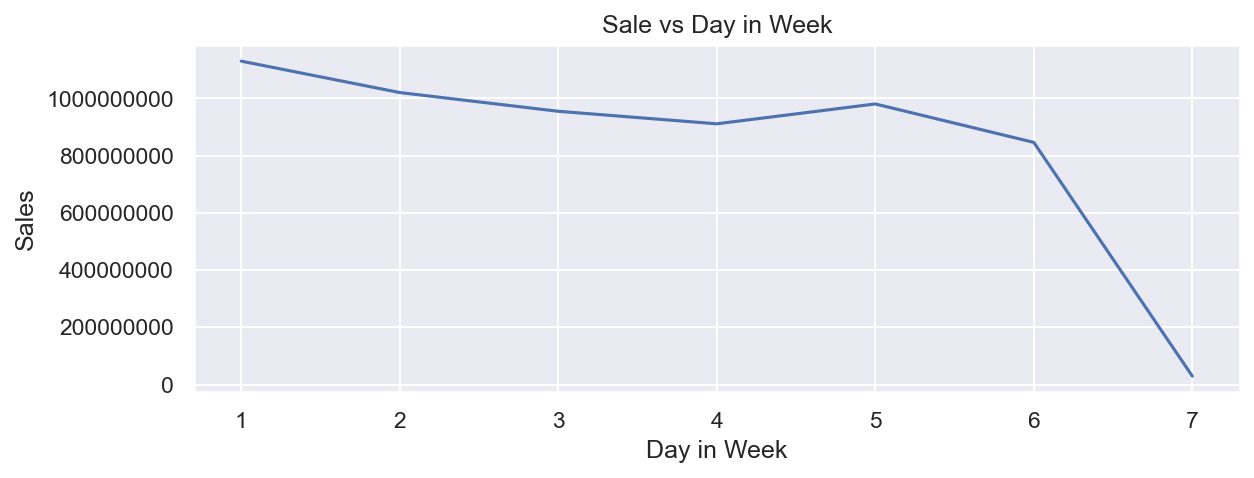

In [23]:
plt.figure(figsize=(9,3))
plt.plot(seasonality_df.groupby('DayOfWeek')['Sales'].sum())
plt.ticklabel_format(style='plain', axis='y')
plt.title("Sale vs Day in Week")
plt.xlabel('Day in Week')
plt.ylabel('Sales')
plt.show()

##### Sales x Month

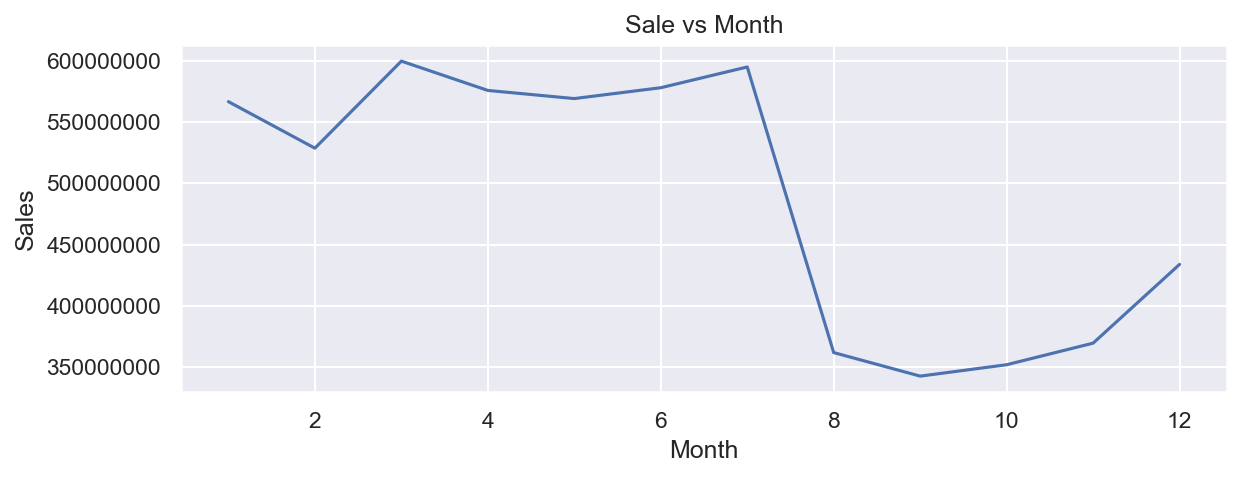

In [24]:
plt.figure(figsize=(9,3))
plt.plot(seasonality_df.groupby('Month')['Sales'].sum())
plt.title("Sale vs Month")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

##### Sales x Customers

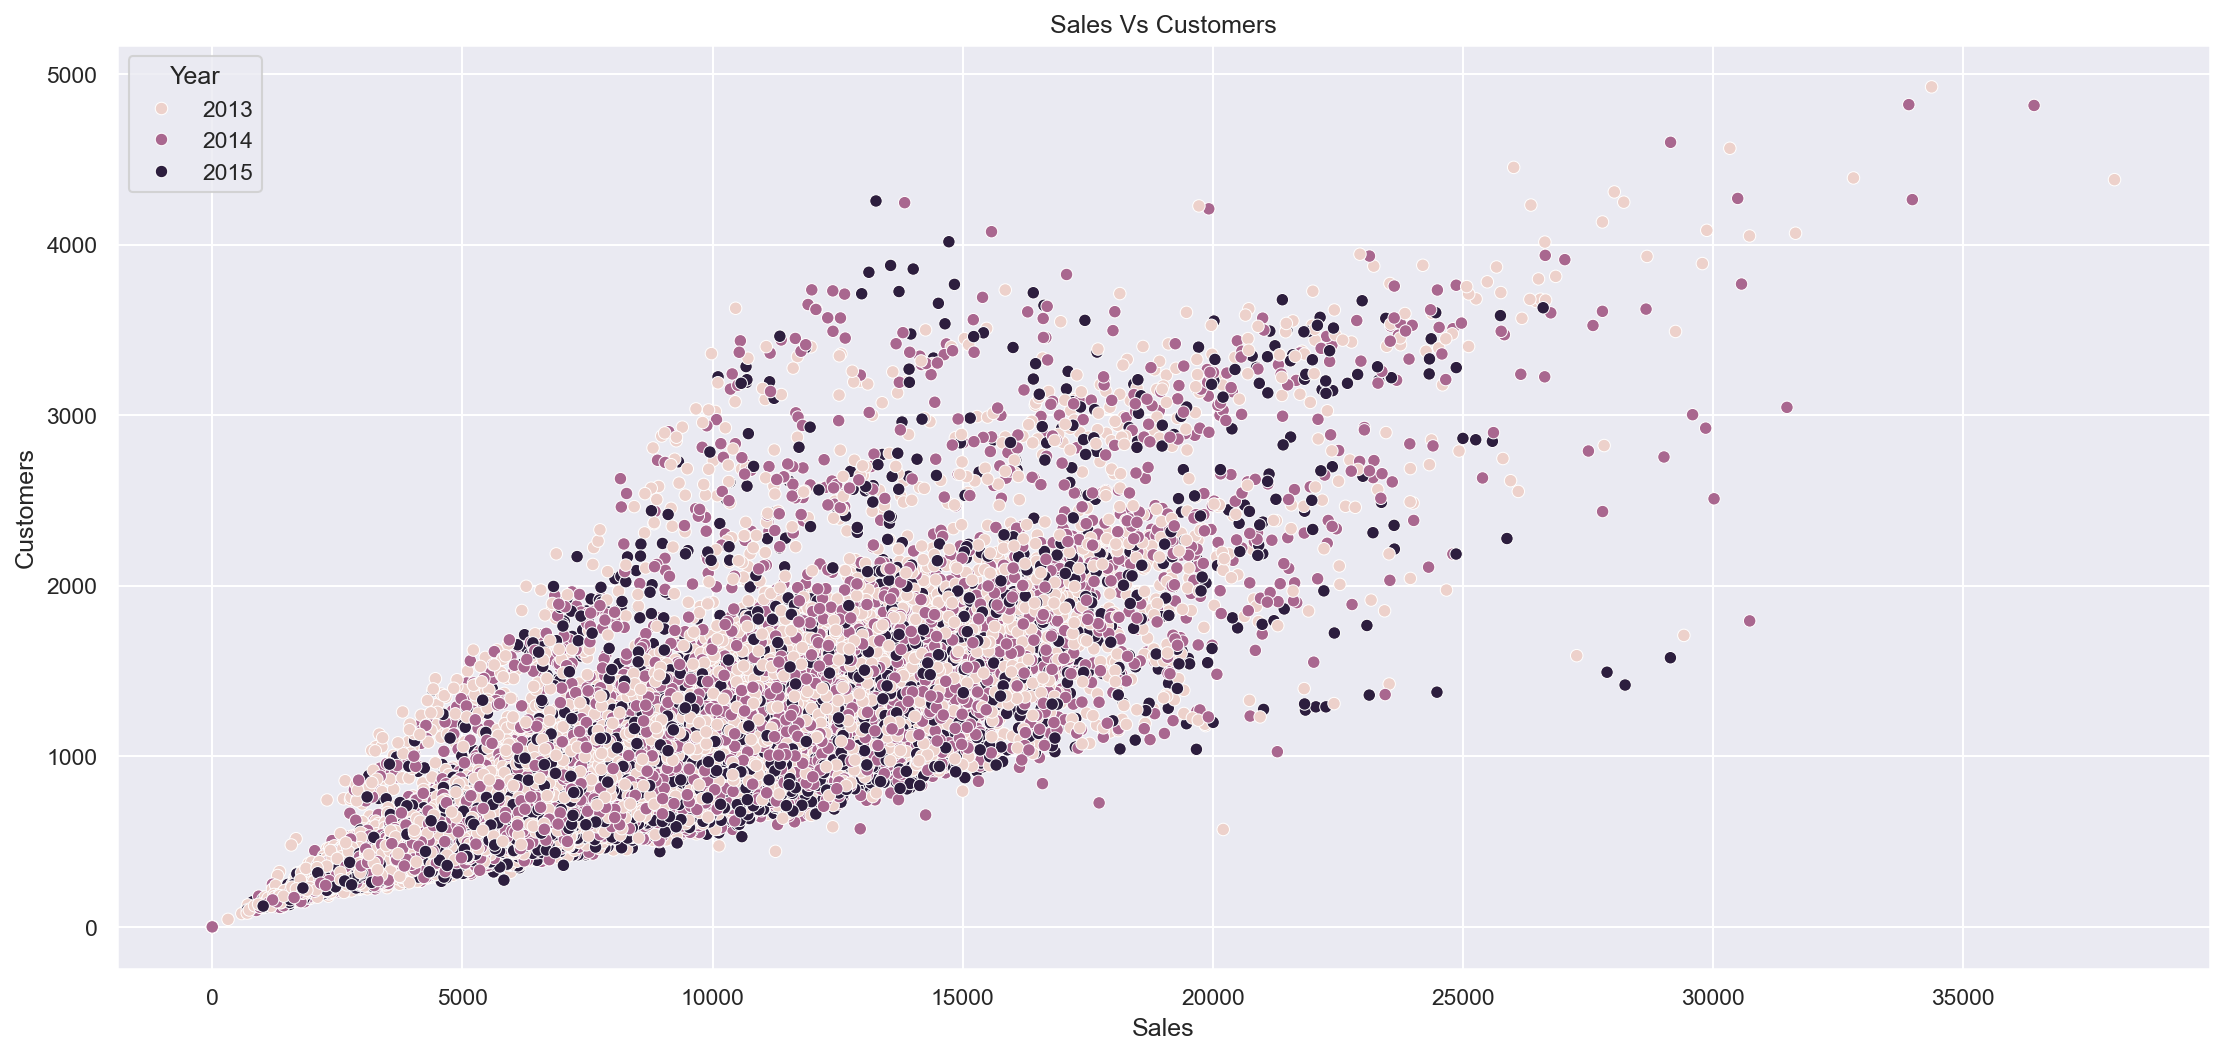

In [25]:
plt.figure(figsize=(18,8))

temp_df = seasonality_df.sample(100000)

_ = sns.scatterplot(data=temp_df, x="Sales", y="Customers", hue='Year')

plt.title("Sales Vs Customers")

plt.show()

##### Sales & Customers by Year

In [26]:
valid_fields = ['Sales', 'Customers']

temp_df = seasonality_df[valid_fields].groupby(seasonality_df['Year']).sum()

temp_df

Sales      Customers
Year                                
2013 2,302,876,084.00 256,004,425.00
2014 2,180,804,896.00 240,488,971.00
2015 1,389,499,643.00 147,548,359.00

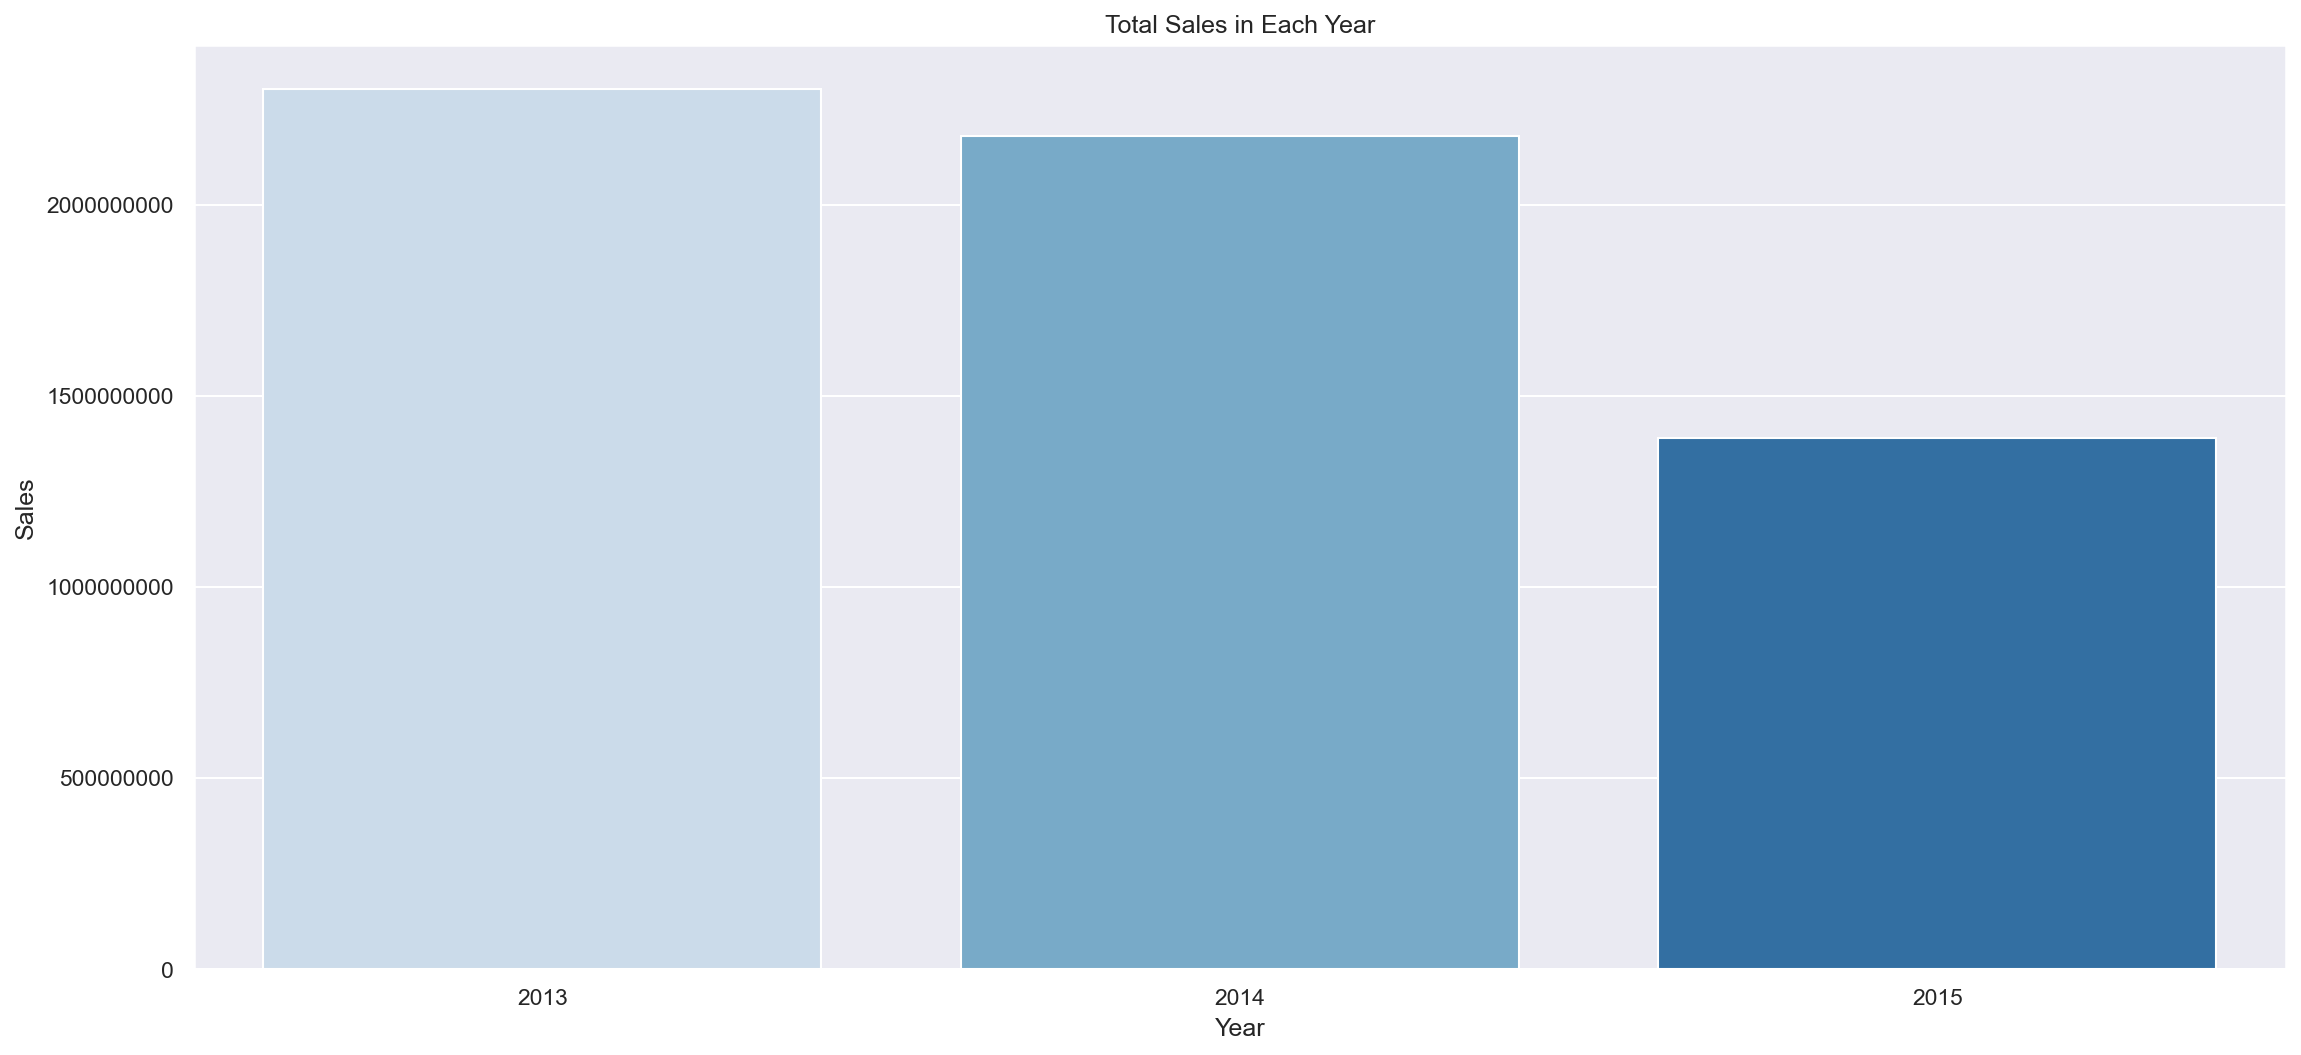

In [27]:
plt.figure(figsize=(18,8))

_ = sns.barplot(data=temp_df, x=temp_df.index, y=temp_df.Sales, palette='Blues')

plt.title("Total Sales in Each Year")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

##### Trends

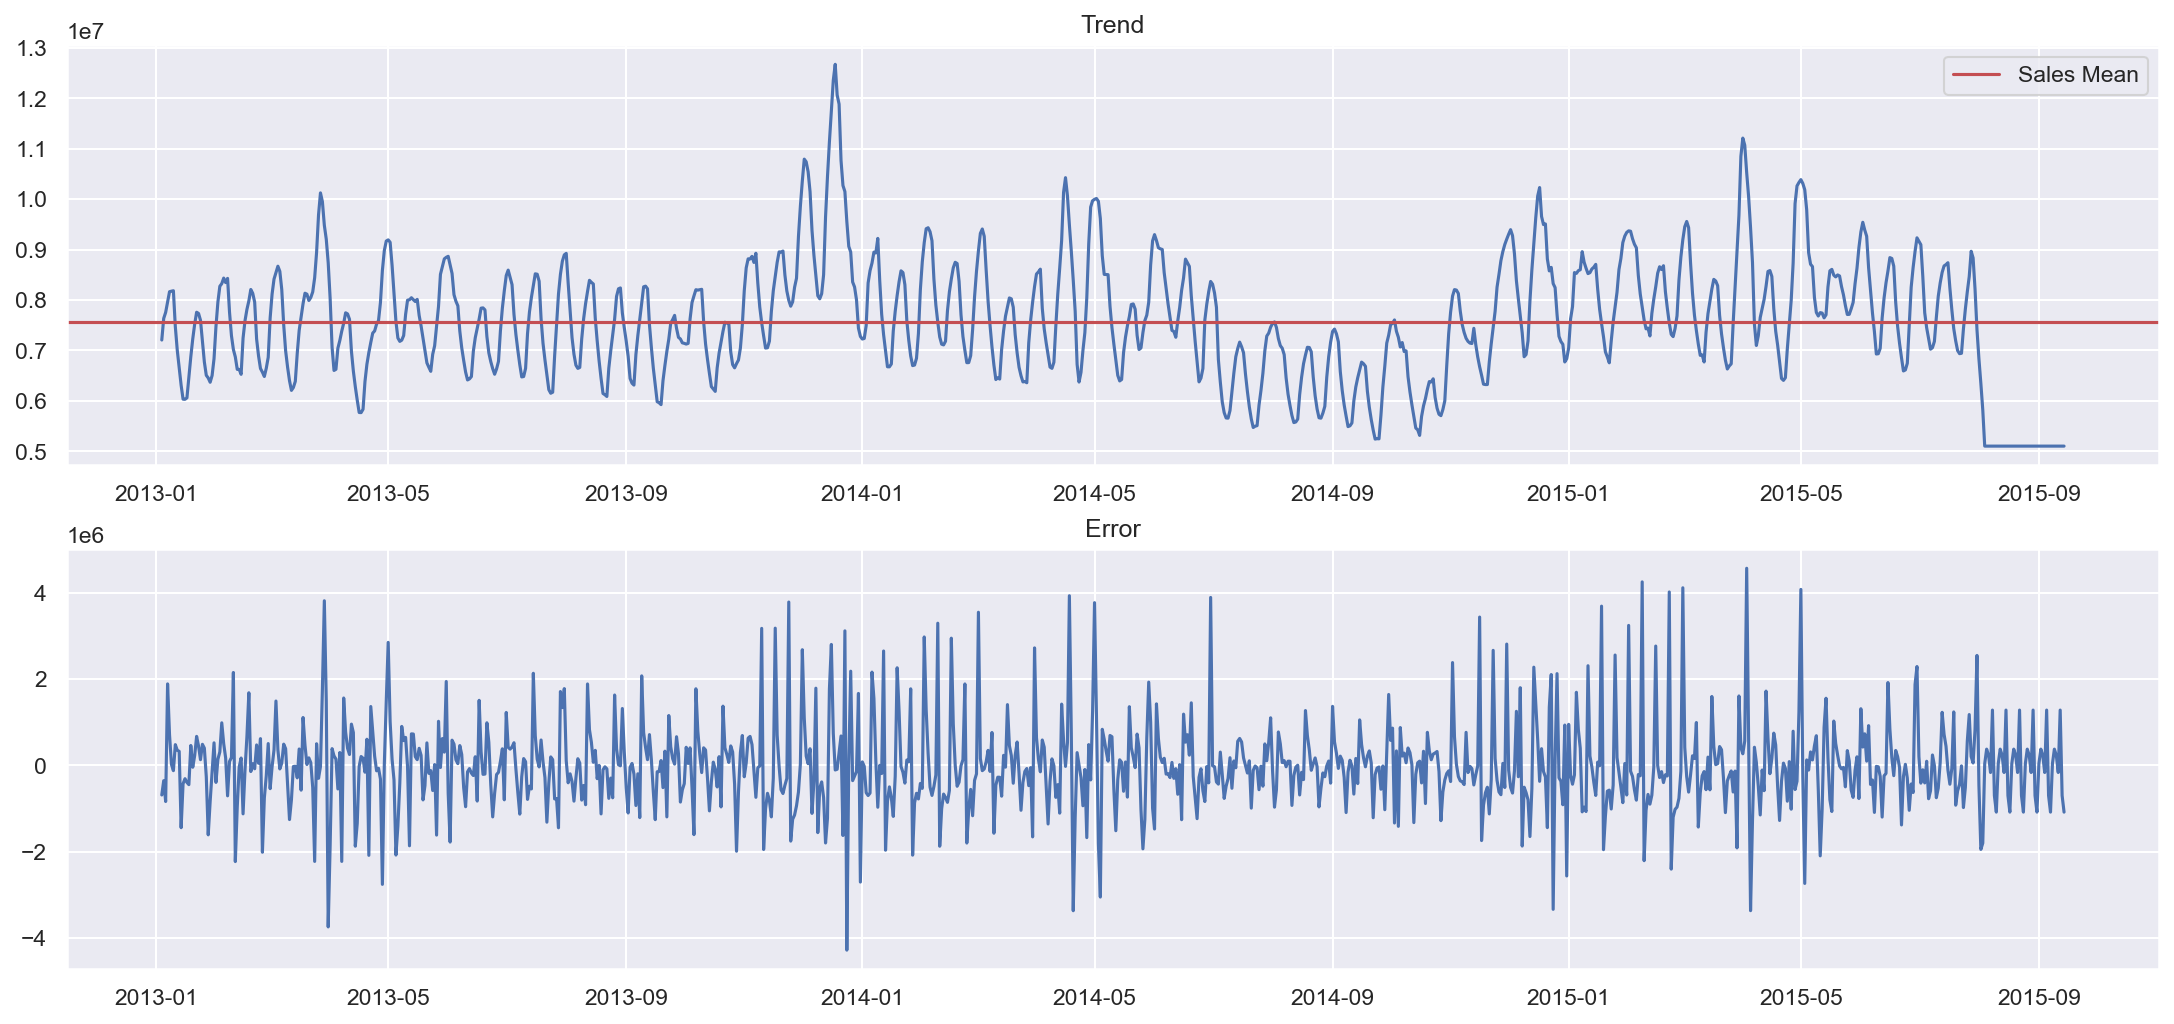

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

temp_df = seasonality_df.copy()
temp_df.Date = pd.to_datetime(temp_df.Date)
temp_df.index = temp_df.Date
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df[['Sales']]
temp_df = temp_df.groupby(temp_df.index).sum()
# result = seasonal_decompose(x=temp_df, model='additive', extrapolate_trend=52)
result = seasonal_decompose(x=temp_df, model='additive')

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
ax1.plot(result.trend)
ax1.axhline(y = temp_df.Sales.mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax1.set_title("Trend")
ax2.plot(result.resid)
ax2.set_title("Error")
ax1.legend()
plt.show()

## Data Preparation

### Prepare DataFrame

In [29]:
df

Store  DayOfWeek        Date     Sales  Customers  Open  Promo  \
0          1          5  2015-07-31  5,263.00     555.00  1.00      1   
1          2          5  2015-07-31  6,064.00     625.00  1.00      1   
2          3          5  2015-07-31  8,314.00     821.00  1.00      1   
3          4          5  2015-07-31 13,995.00   1,498.00  1.00      1   
4          5          5  2015-07-31  4,822.00     559.00  1.00      1   
...      ...        ...         ...       ...        ...   ...    ...   
41083   1111          6  2015-08-01       NaN        NaN  1.00      0   
41084   1112          6  2015-08-01       NaN        NaN  1.00      0   
41085   1113          6  2015-08-01       NaN        NaN  1.00      0   
41086   1114          6  2015-08-01       NaN        NaN  1.00      0   
41087   1115          6  2015-08-01       NaN        NaN  1.00      0   

      StateHoliday  SchoolHoliday        Id  
0                0              1       NaN  
1                0              1       NaN  
2                0              1       NaN  
3                0              1       NaN  
4                0              1       NaN  
...            ...            ...       ...  
41083            0              0 41,084.00  
41084            0              0 41,085.00  
41085            0              0 41,086.00  
41086            0              0 41,087.00  
41087            0              1 41,088.00  

[1058297 rows x 10 columns]

In [30]:
# prep_df = df.copy()[['Store', 'Date', 'Sales', 'Customers']]

prep_df = df.copy()[['Sales', 'Customers']]

prep_df

Sales  Customers
0      5,263.00     555.00
1      6,064.00     625.00
2      8,314.00     821.00
3     13,995.00   1,498.00
4      4,822.00     559.00
...         ...        ...
41083       NaN        NaN
41084       NaN        NaN
41085       NaN        NaN
41086       NaN        NaN
41087       NaN        NaN

[1058297 rows x 2 columns]

### Drop Null Values

In [31]:
prep_df.isnull().sum()

Sales        41088
Customers    41088
dtype: int64

In [32]:
prep_df = prep_df.dropna()

prep_df

Sales  Customers
0        5,263.00     555.00
1        6,064.00     625.00
2        8,314.00     821.00
3       13,995.00   1,498.00
4        4,822.00     559.00
...           ...        ...
1017204      0.00       0.00
1017205      0.00       0.00
1017206      0.00       0.00
1017207      0.00       0.00
1017208      0.00       0.00

[1017209 rows x 2 columns]

In [33]:
prep_df.isnull().sum()

Sales        0
Customers    0
dtype: int64

### Drop Zero Values

#### Count 0-value Customers

In [34]:
customers_zero_counts = (prep_df["Customers"] == 0).sum()

customers_zero_counts

172869

#### Count 0-value Sales

In [35]:
sales_zero_counts = (prep_df["Sales"] == 0).sum()

sales_zero_counts

172871

#### Count 0-value Customers + Sales

In [36]:
total_counts = ((prep_df["Sales"] == 0) | (prep_df["Customers"] == 0)).sum()

total_counts

172871

#### Remove 0-values

In [37]:
# prep_df = prep_df.loc[~(prep_df==0).all(axis=1)]
# With | => 844,340
# With & => 844,338
prep_df = prep_df[(prep_df['Customers'] > 0) & (prep_df['Sales'] > 0)]

prep_df

Sales  Customers
0        5,263.00     555.00
1        6,064.00     625.00
2        8,314.00     821.00
3       13,995.00   1,498.00
4        4,822.00     559.00
...           ...        ...
1016776  3,375.00     566.00
1016827 10,765.00   2,377.00
1016863  5,035.00   1,248.00
1017042  4,491.00   1,039.00
1017190  5,961.00   1,405.00

[844338 rows x 2 columns]

#### Confirm 0-values Dropped

In [38]:
# customers_zero_counts = (prep_df_2["Customers"] == 0).sum()

# customers_zero_counts

# sales_zero_counts = (prep_df_2["Sales"] == 0).sum()

# sales_zero_counts

total_counts = ((prep_df["Sales"] == 0) | (prep_df["Customers"] == 0)).sum()

total_counts

0

### Drop Dupes

#### Check for Dupes

In [39]:
prep_df[prep_df.duplicated(["Sales", "Customers"])].sort_values(by='Sales')

Sales  Customers
567535     999.00     180.00
816741     999.00     111.00
504616   1,119.00     145.00
738657   1,135.00     169.00
684661   1,172.00     171.00
...           ...        ...
627785  16,662.00   1,255.00
853020  16,938.00   1,928.00
409520  16,972.00   1,346.00
764892  17,873.00   1,852.00
1007736 18,885.00   2,989.00

[85727 rows x 2 columns]

In [60]:
prep_df

Sales  Customers
0        5,263.00     555.00
1        6,064.00     625.00
2        8,314.00     821.00
3       13,995.00   1,498.00
4        4,822.00     559.00
...           ...        ...
1016776  3,375.00     566.00
1016827 10,765.00   2,377.00
1016863  5,035.00   1,248.00
1017042  4,491.00   1,039.00
1017190  5,961.00   1,405.00

[844338 rows x 2 columns]

In [62]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(prep_df[['Sales']])
transformer
transformer.transform(prep_df[['Sales']])

array([[-0.31590974],
       [-0.08711797],
       [ 0.55555556],
       ...,
       [-0.38103399],
       [-0.53641817],
       [-0.11653813]])

In [63]:
from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(prep_df[['Sales']])
transformer
transformer.transform(prep_df[['Sales']])

array([[0.1256957 ],
       [0.14499458],
       [0.19920492],
       ...,
       [0.12020239],
       [0.10709553],
       [0.14251295]])

#### Remove Dupes

In [40]:
# data_df = data_df.drop_duplicates()

# data_df

### Quick Plots

We have removed
- null values
- zero values
- any dupes

Next, we want to check whether the data has any outliers

#### Sales 

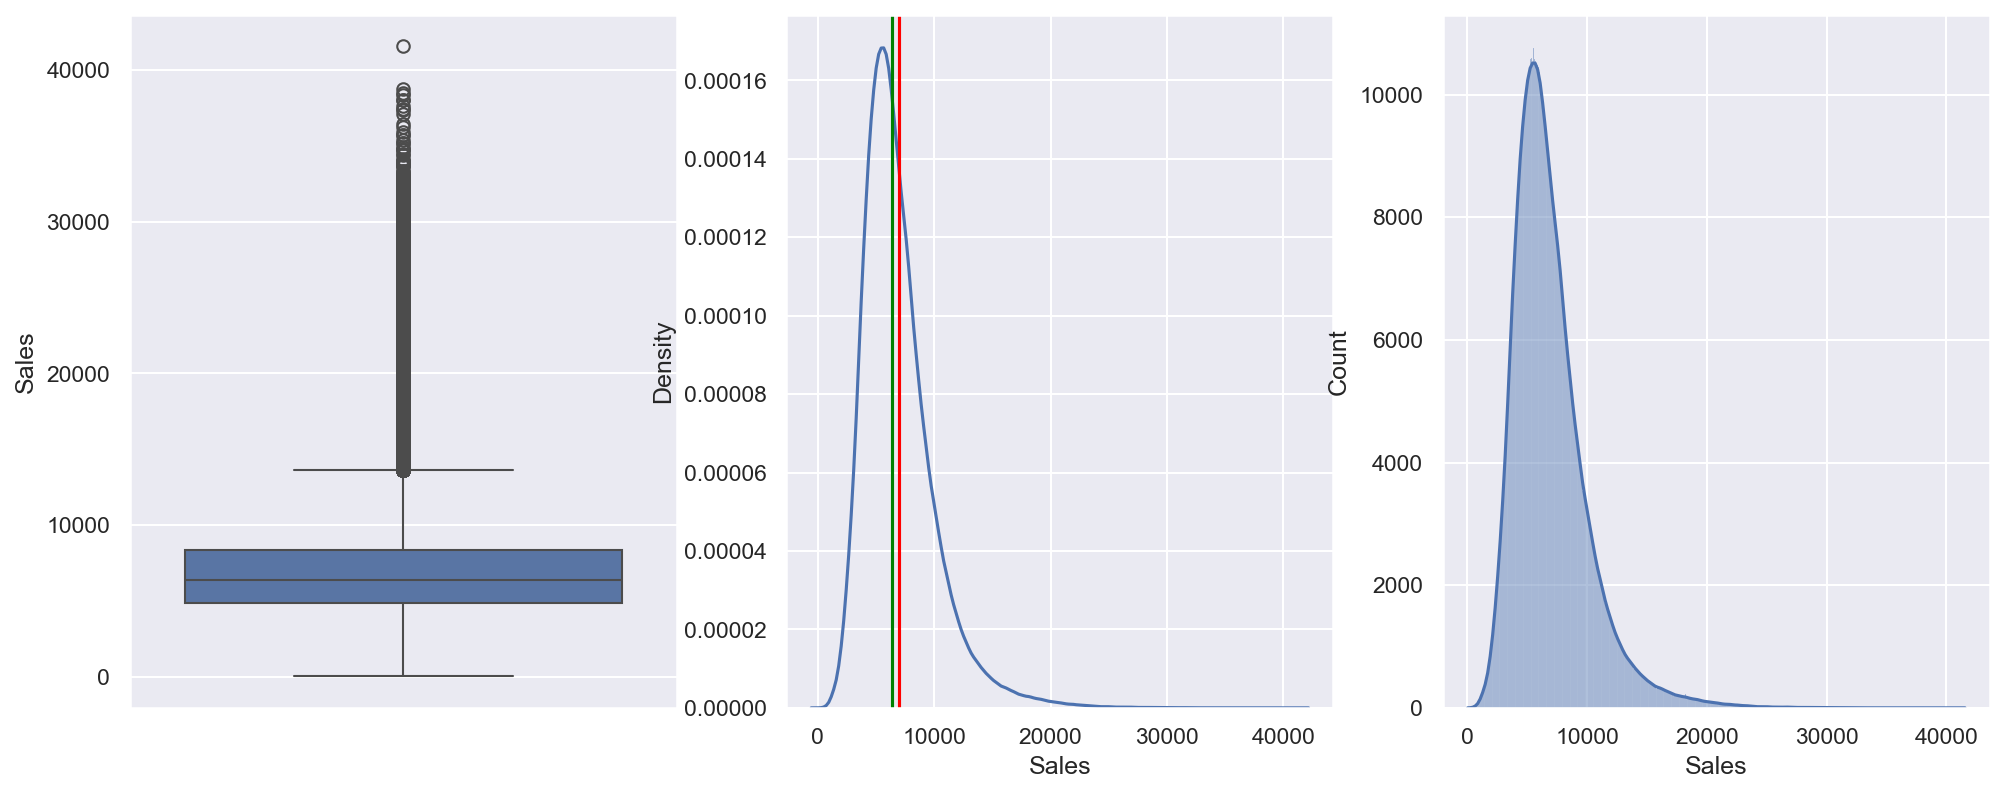

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,6)) 

sns.boxplot(prep_df['Sales'], ax=ax1)
sns.kdeplot(prep_df['Sales'], ax=ax2)
sns.histplot(data=prep_df, x="Sales", kde=True)

ax2.axvline(prep_df['Sales'].mean(), color='red')
ax2.axvline(prep_df['Sales'].median(), color='green')

plt.show()

#### Customers

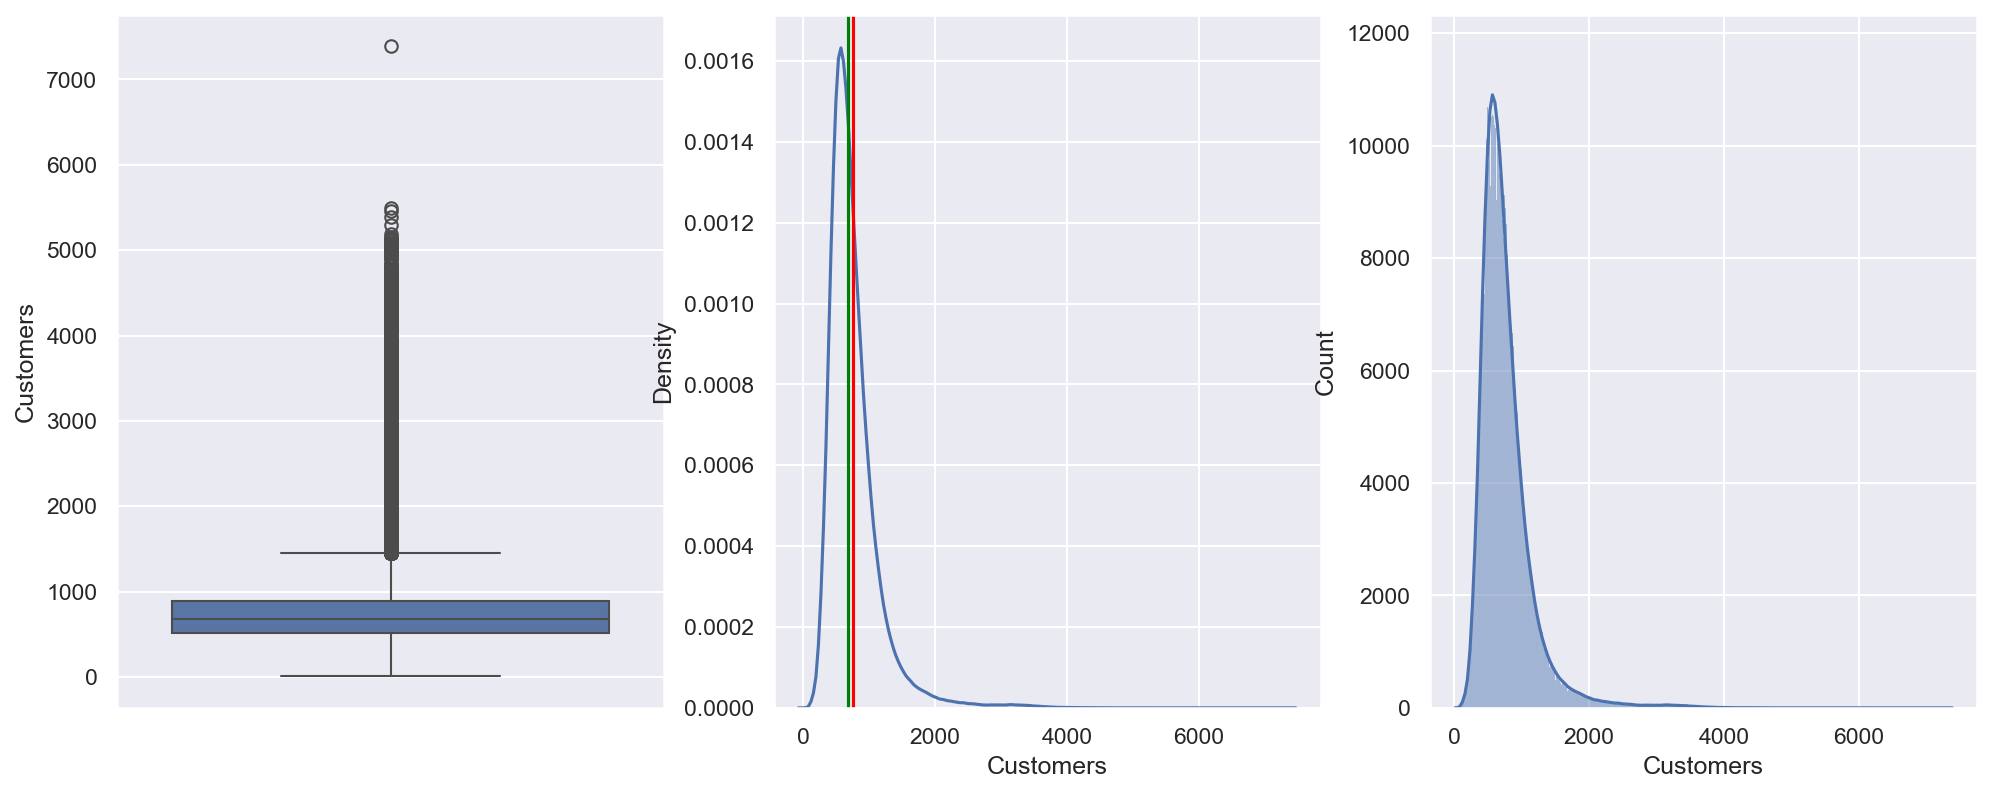

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,6)) 

sns.boxplot(prep_df['Customers'], ax=ax1)
sns.kdeplot(prep_df['Customers'], ax=ax2)
sns.histplot(data=prep_df, x="Customers", kde=True)

ax2.axvline(prep_df['Customers'].mean(), color='red')
ax2.axvline(prep_df['Customers'].median(), color='green')

plt.show()

### Handle Outliers

#### Helper Functions

In [43]:
def detect_outliers_zscore(data: pd.Series, feature: str) -> tuple[pd.DataFrame, float, float]:
    outliers = {
        feature: [],
        f"{feature}zScore": []
    }
    
    thres = 3
    mean = np.mean(data)  # or np.nanmean(data.values.tolist())
    std = np.std(data)  # or np.nanstd(data.values.tolist())
    
    for i in data:
        z_score = (i - mean) / std
        if (np.abs(z_score) > thres):
            outliers[feature].append(i)
            outliers[f"{feature}zScore"].append(z_score)
    
    return pd.DataFrame(outliers).sort_values(by=f"{feature}zScore", na_position='last'), mean, std

In [44]:
def detect_outliers_iqr(data: pd.Series, feature: str) -> tuple[pd.DataFrame, float, float]:
    outliers = {
        feature: []
    }
    data = sorted(data)
    
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    
    IQR = q3-q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (1.5 * IQR)
    
    for i in data: 
        if (i < lwr_bound or i > upr_bound):
            outliers[feature].append(i)
            
    return pd.DataFrame(outliers).sort_values(by=feature, na_position='last'), upr_bound, lwr_bound

In [45]:
def impute_zscore_outliers(data_f: pd.DataFrame, feature: str) -> pd.DataFrame:
    # Impute based on the zScore using the median
    upper_limit = data_f[feature].mean() + 3 * data_f[feature].std()
    lower_limit = data_f[feature].mean() - 3 * data_f[feature].std()

    data_f[feature] = np.where(
        data_f[feature] > upper_limit,
        data_f[feature].mode(),
        # data_f[feature].median(),
        np.where(
            data_f[feature] < lower_limit,
            data_f[feature].mode(),
            data_f[feature]
        )
    )
    
    return data_f.sort_values(by=feature, na_position="last")

In [46]:
def cap_zscore_outliers(data_f: pd.DataFrame, feature: str) -> pd.DataFrame:
    # Cap/Replace based on the zScore using the upper and lower limits
    upper_limit = data_f[feature].mean() + 3 * data_f[feature].std()
    lower_limit = data_f[feature].mean() - 3 * data_f[feature].std()

    data_f[feature] = np.where(
        data_f[feature] > upper_limit,
        upper_limit,
        np.where(
            data_f[feature] < lower_limit,
            lower_limit,
            data_f[feature]
        )
    )
    
    return data_f.sort_values(by=feature, na_position="last")

#### Using zScore

In [47]:
customers_outliers_z, cust_mean, cust_std = detect_outliers_zscore(prep_df.Customers, 'Customers')

customers_outliers_z, cust_mean, cust_std

(       Customers  CustomerszScore
 11461   1,967.00             3.00
 5467    1,967.00             3.00
 14646   1,967.00             3.00
 6298    1,967.00             3.00
 7181    1,967.00             3.00
 ...          ...              ...
 6989    5,297.00            11.30
 6754    5,387.00            11.53
 1539    5,458.00            11.70
 4979    5,494.00            11.79
 15244   7,388.00            16.51
 
 [15519 rows x 2 columns],
 762.777166253325,
 401.1939149876185)

In [48]:
sales_outliers_z, sales_mean, sales_std = detect_outliers_zscore(prep_df['Sales'], 'Sales')

sales_outliers_z, sales_mean, sales_std

(          Sales  SaleszScore
 3032  16,268.00         3.00
 10281 16,268.00         3.00
 3417  16,268.00         3.00
 12787 16,268.00         3.00
 9778  16,268.00         3.00
 ...         ...          ...
 5965  38,037.00        10.01
 1163  38,367.00        10.12
 1346  38,484.00        10.16
 1745  38,722.00        10.23
 588   41,551.00        11.15
 
 [13443 rows x 2 columns],
 6955.959133664481,
 3103.813677472827)

#### Using IQR

In [49]:
customers_outliers_iqr, cust_upper_bound, cust_lower_bound = detect_outliers_iqr(prep_df.Customers, 'Customers')

customers_outliers_iqr, cust_upper_bound, cust_lower_bound

(       Customers
 0       1,455.00
 63      1,455.00
 62      1,455.00
 61      1,455.00
 60      1,455.00
 ...          ...
 40848   5,297.00
 40849   5,387.00
 40850   5,458.00
 40851   5,494.00
 40852   7,388.00
 
 [40853 rows x 1 columns],
 1454.0,
 -42.0)

In [50]:
sales_outliers_iqr, sales_upper_bound, sales_lower_bound = detect_outliers_iqr(prep_df['Sales'], 'Sales')

sales_outliers_iqr, sales_upper_bound, sales_lower_bound

(          Sales
 0     13,612.00
 1     13,612.00
 2     13,612.00
 3     13,612.00
 4     13,612.00
 ...         ...
 30764 38,037.00
 30765 38,367.00
 30766 38,484.00
 30767 38,722.00
 30768 41,551.00
 
 [30769 rows x 1 columns],
 13611.5,
 -392.5)

#### Imputing - zScore

In [51]:
impute_df = prep_df.copy()

impute_df = impute_zscore_outliers(data_f=impute_df, feature='Customers')

impute_df

Sales  Customers
273387     46.00       8.00
202712    124.00      13.00
846592    133.00      18.00
996161    297.00      36.00
941137    286.00      40.00
...          ...        ...
805782 10,135.00   1,966.00
422630 16,055.00   1,966.00
437121 16,174.00   1,966.00
244725 20,086.00   1,966.00
171064 14,427.00   1,966.00

[844338 rows x 2 columns]

In [52]:
impute_df = impute_df.copy()

impute_df = impute_zscore_outliers(data_f=impute_df, feature='Sales')

impute_df

Sales  Customers
273387     46.00       8.00
202712    124.00      13.00
846592    133.00      18.00
941137    286.00      40.00
996161    297.00      36.00
...          ...        ...
212111 16,267.00     560.00
924635 16,267.00   1,476.00
781308 16,267.00   1,657.00
866113 16,267.00     560.00
619282 16,267.00   1,290.00

[844338 rows x 2 columns]

In [53]:
# prep_df[((prep_df.zscore_Customers < -3) | (prep_df.zscore_Customers > 3)) & ((prep_df.zscore_Sales < -3) | (prep_df.zscore_Sales > 3))].sort_values(by=["Sales"])

##### Plots

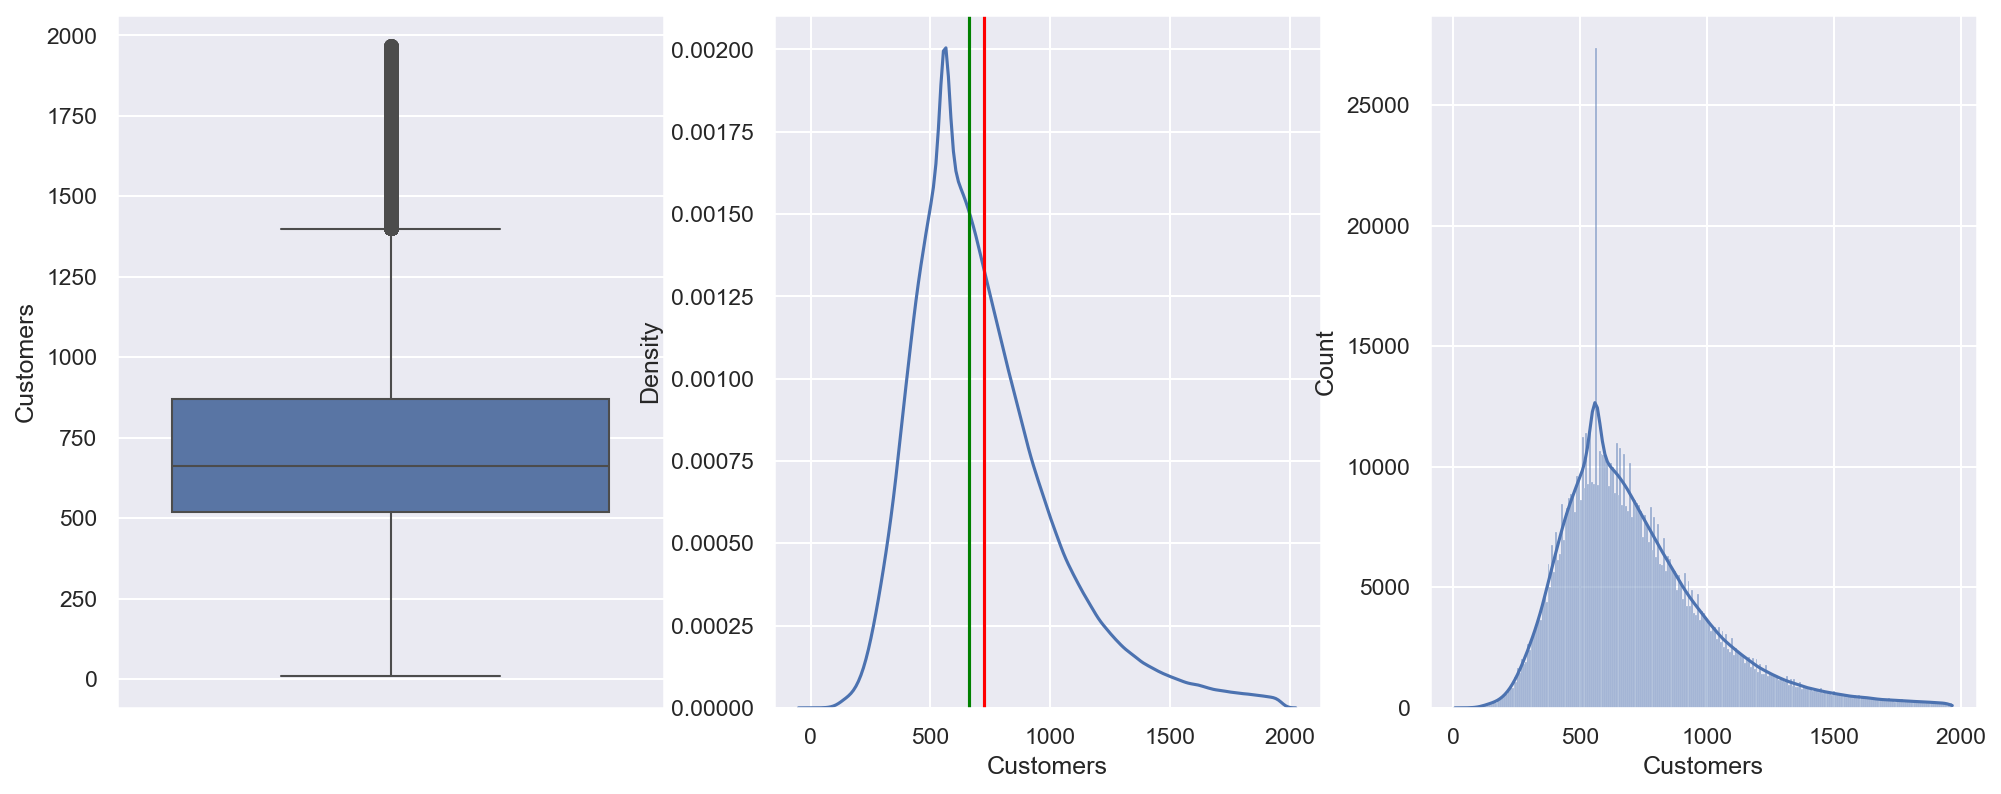

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,6)) 

sns.boxplot(impute_df['Customers'], ax=ax1)
sns.kdeplot(impute_df['Customers'], ax=ax2)
sns.histplot(impute_df['Customers'], kde=True, ax=ax3)

ax2.axvline(impute_df['Customers'].mean(), color='red')
ax2.axvline(impute_df['Customers'].median(), color='green')

plt.show()

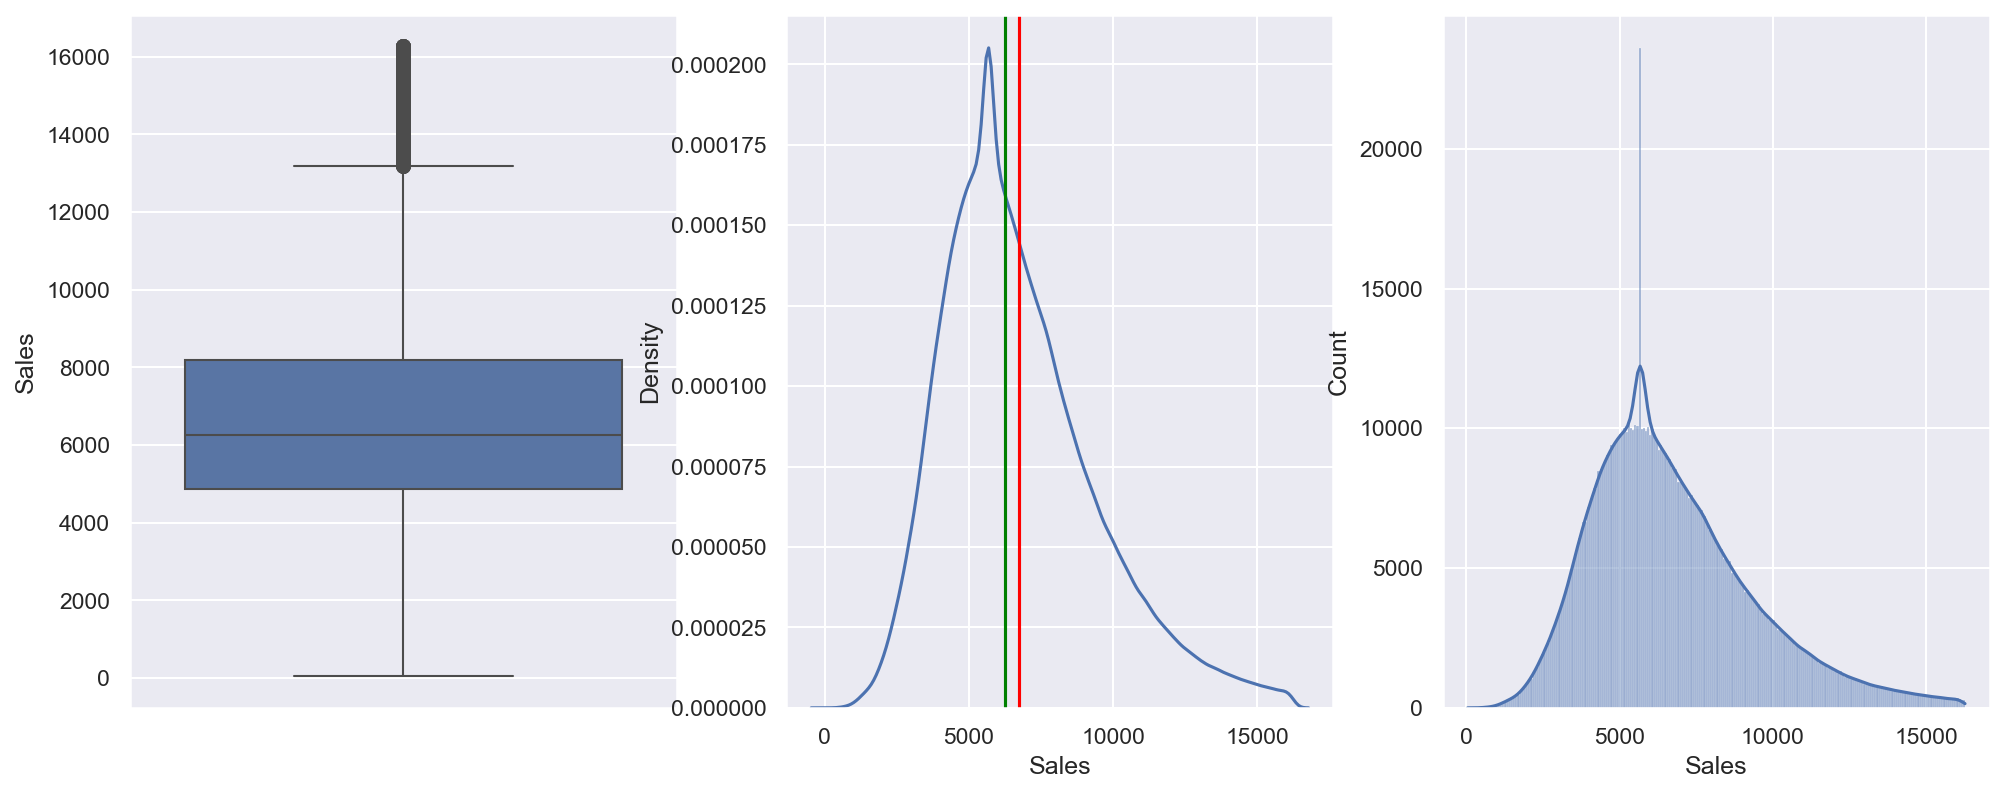

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,6)) 

sns.boxplot(impute_df['Sales'], ax=ax1)
sns.kdeplot(impute_df['Sales'], ax=ax2)
sns.histplot(impute_df['Sales'], kde=True, ax=ax3)

ax2.axvline(impute_df['Sales'].mean(), color='red')
ax2.axvline(impute_df['Sales'].median(), color='green')

plt.show()

#### Capping - zScore

In [56]:
cap_df = prep_df.copy()

cap_df = cap_zscore_outliers(data_f=cap_df, feature='Customers')

cap_df.drop_duplicates()

cap_df

Sales  Customers
273387     46.00       8.00
202712    124.00      13.00
846592    133.00      18.00
996161    297.00      36.00
941137    286.00      40.00
...          ...        ...
275648 17,015.00   1,966.36
275635  9,669.00   1,966.36
723582 12,823.00   1,966.36
723618  8,587.00   1,966.36
750426 24,517.00   1,966.36

[844338 rows x 2 columns]

In [57]:
cap_df = cap_df.copy()

cap_df = cap_zscore_outliers(data_f=cap_df, feature='Sales')

cap_df.drop_duplicates()

cap_df

Sales  Customers
273387     46.00       8.00
202712    124.00      13.00
846592    133.00      18.00
941137    286.00      40.00
996161    297.00      36.00
...          ...        ...
346430 16,267.41   1,772.00
799425 16,267.41   1,966.36
204606 16,267.41   1,966.36
213781 16,267.41   1,966.36
750426 16,267.41   1,966.36

[844338 rows x 2 columns]

##### Plots

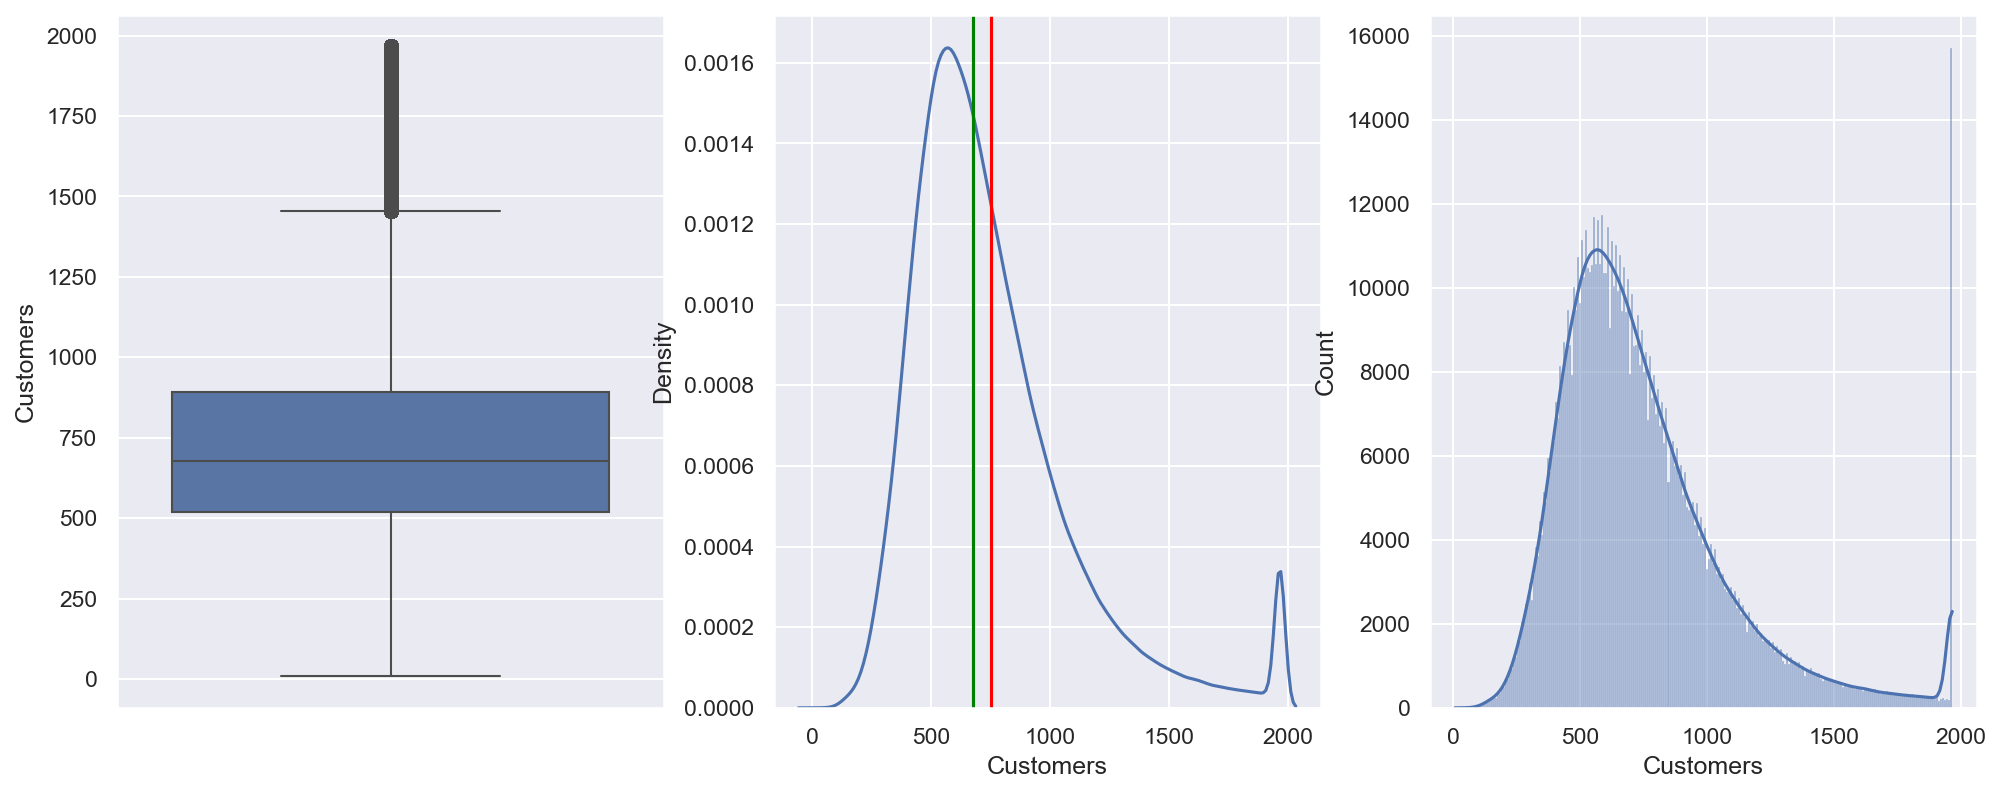

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,6)) 

sns.boxplot(cap_df['Customers'], ax=ax1)
sns.kdeplot(cap_df['Customers'], ax=ax2)
sns.histplot(cap_df['Customers'], kde=True, ax=ax3)

ax2.axvline(cap_df['Customers'].mean(), color='red')
ax2.axvline(cap_df['Customers'].median(), color='green')

plt.show()

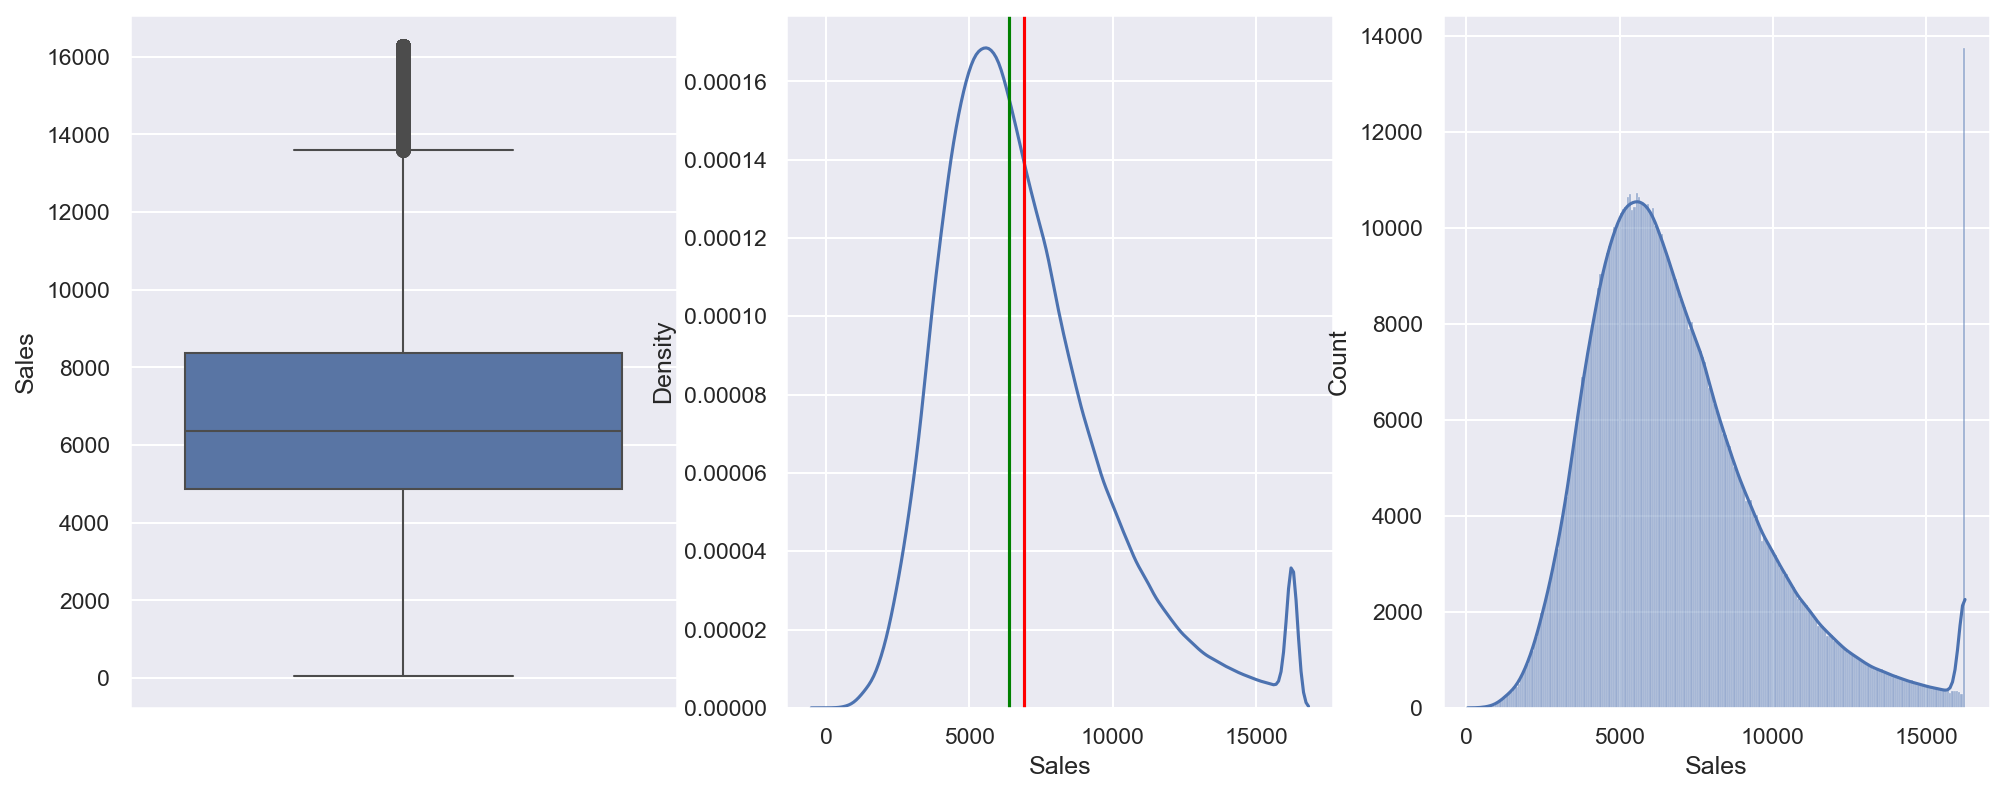

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,6)) 

sns.boxplot(cap_df['Sales'], ax=ax1)
sns.kdeplot(cap_df['Sales'], ax=ax2)
sns.histplot(cap_df['Sales'], kde=True, ax=ax3)

ax2.axvline(cap_df['Sales'].mean(), color='red')
ax2.axvline(cap_df['Sales'].median(), color='green')

plt.show()

## Modelling

## Conclusions